### Libraries

In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import weakref
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report
from torch import nn
import torch.nn.functional as F
import types
from transformers.modeling_outputs import SemanticSegmenterOutput
from enum import Enum
from torchvision import transforms
import nibabel as nib
from pathlib import Path
import math
from collections import defaultdict
from medsyn.tasks import (
    CutPastePatchBlender,
    SmoothIntensityChangeTask,
    GaussIntensityChangeTask,
    SinkDeformationTask,
    SourceDeformationTask,
    IdentityTask,
)
from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
from torchinfo import summary
import yaml
from easydict import EasyDict
import math
import argparse
import warnings
from utils.misc_helper import (
    AverageMeter,
    compute_imagewise_metrics,
    compute_pixelwise_metrics,
    get_current_time,
    create_logger,
    set_seed
)
from utils.losses import FocalLoss, BinaryDiceLoss

import pprint
from tqdm import tqdm
import multiprocessing
import numpy as np
import random
from pathlib import Path
import json

In [2]:
import torch.utils.data as data
from torch.utils.data import Dataset, random_split, DataLoader, Subset
from PIL import Image
from pathlib import Path
from collections import defaultdict

In [3]:
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, create_test_image_3d
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, ResNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.11.4
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.49.0
mlflow version: 2.15.0
pynrrd version: 1.0.0
clearml version: 1.16.3rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Original model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [62]:
num_workers = max(1, multiprocessing.cpu_count() - 1) #!
num_workers = 0 #!

In [6]:
model = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-swin-base"
)

processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
summary(model, input_size=(8, 3, 512, 512))  # (B,C,H,W)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [SwinBackbone: 1, SwinEmbeddings: 2, SwinPatchEmbeddings: 3, Conv2d: 4, LayerNorm: 3, Dropout: 3, SwinEncoder: 2, SwinStage: 4, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, Identity: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinPatchMerging: 5, LayerNorm: 6, Linear: 6, SwinStage: 4, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinPatchMerging: 5, LayerNorm: 6, Linear: 6, SwinStage: 4, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinPatchMerging: 5, LayerNorm: 6, Linear: 6, SwinStage: 4, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, SwinLayer: 6, LayerNorm: 7, SwinAttention: 7, SwinSelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Dropout: 9, SwinSelfOutput: 8, Linear: 9, Dropout: 9, SwinDropPath: 7, LayerNorm: 7, SwinIntermediate: 7, Linear: 8, GELUActivation: 8, SwinOutput: 7, Linear: 8, Dropout: 8, LayerNorm: 3, LayerNorm: 3, LayerNorm: 3, LayerNorm: 3, UperNetHead: 1, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetPyramidPoolingModule: 2, UperNetPyramidPoolingBlock: 3, AdaptiveAvgPool2d: 4, UperNetConvModule: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, UperNetPyramidPoolingBlock: 3, AdaptiveAvgPool2d: 4, UperNetConvModule: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, UperNetPyramidPoolingBlock: 3, AdaptiveAvgPool2d: 4, UperNetConvModule: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, UperNetPyramidPoolingBlock: 3, AdaptiveAvgPool2d: 4, UperNetConvModule: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, UperNetConvModule: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, UperNetConvModule: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, Conv2d: 2, UperNetFCNHead: 1, Sequential: 2, UperNetConvModule: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 2]

In [8]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

#summary(model, input_size=(8, 3, 224, 224))

# REMEMBER: UperNetHead is the actual head, UperNetFCNHead is used only during training
# to check whether compression is working

In [9]:
def new_forward(self, pixel_values=None, output_hidden_states=None, return_dict=True, **kwargs):
    # get input shape
    input_shape = pixel_values.shape if pixel_values is not None else None
    # run backbone + head
    outputs = self.backbone(pixel_values)
    feats = outputs.feature_maps

    logits = self.decode_head(feats)


    # fix interpolation: only use H, W
    if input_shape is not None:
        h, w = input_shape[-2:]
        logits = F.interpolate(logits, size=(h, w),
                               mode="bilinear", align_corners=False)
    return SemanticSegmenterOutput(logits=logits)

model.forward = types.MethodType(new_forward, model)


In [10]:
img3d, mask3d = create_test_image_3d(64, 64, 64, num_seg_classes=2, channel_dim=0)

img3d = torch.tensor(img3d)   # [1, 64, 64, 64]
mask3d = torch.tensor(mask3d)

slice_idx = 32
img2d = img3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()  # duplicates the last dimension 3 times -> fake RGB
# because UPerNet expects a 3-channel RGB input

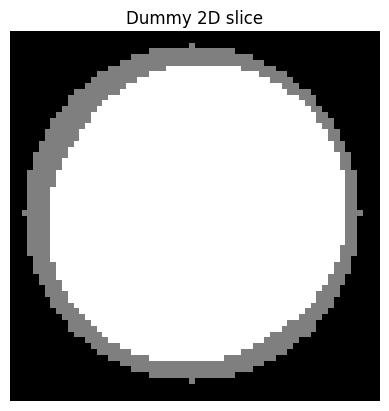

In [11]:
plt.imshow(img2d.astype("float32"), cmap="gray")  # or just plt.imshow(img2d) since it's RGB
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [12]:
mask2d = mask3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


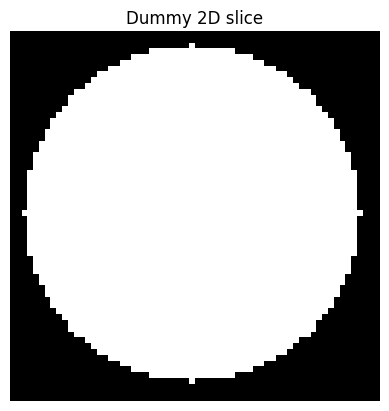

In [13]:
plt.imshow(mask2d.astype("float32"), cmap="gray")
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [14]:
# pre-process into the tensor-shape and normalization that the model expects
inputs = processor(images=img2d, return_tensors="pt")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [15]:
inputs['pixel_values'].shape

torch.Size([1, 3, 512, 512])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs.to(device);

In [17]:
model.to(device)  # moves all params/buffers

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # [1, num_classes, H', W']

In [18]:
# 6. Resize back to original size
seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[img2d.shape[:2]])
seg = seg[0].cpu().numpy()

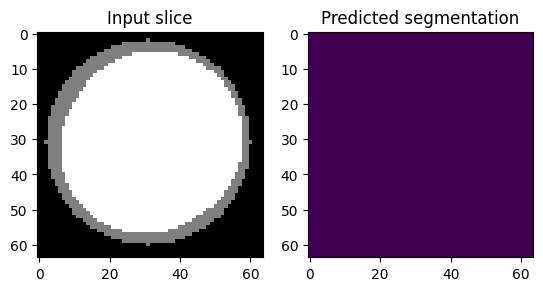

In [19]:
# 7. Visualize
plt.subplot(1,2,1)
plt.imshow(img2d); plt.title("Input slice")
plt.subplot(1,2,2)
plt.imshow(seg, cmap="viridis"); plt.title("Predicted segmentation")
plt.show()

In [20]:
# Access backbone
backbone = model.backbone  # this is SwinModel

# Access patch embedding
print(backbone.embeddings)

SwinEmbeddings(
  (patch_embeddings): SwinPatchEmbeddings(
    (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [21]:
conv2d = backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data

In [22]:
type(inputs)

transformers.image_processing_base.BatchFeature

### Modify to 3D input

In [23]:
def preprocess_3d_volume(volume, depth_size=5, stride=1, mean=None, std=None):
    """
    volume: torch.Tensor [C,D,H,W] or [D,H,W] if single-channel
    depth_size: number of slices per window
    stride: step along depth
    """
    if volume.ndim == 3:
        volume = volume.unsqueeze(0)  # [1,D,H,W]

    C, D, H, W = volume.shape
    windows = []
    for start in range(0, D - depth_size + 1, stride):
        clip = volume[:, start:start+depth_size, :, :]  # [C, depth_size, H, W]

        # normalize like processor (ImageNet mean/std per channel)
        if mean is not None and std is not None:
            for c in range(C):
                clip[c] = (clip[c] - mean[c]) / std[c]

        windows.append(clip)

    # [num_windows, C, depth_size, H, W]
    return torch.stack(windows)


In [24]:
vol = torch.randn(1, 20, 224, 224)  # [C=1, D=20, H,W]
windows = preprocess_3d_volume(vol, depth_size=5, stride=5)
print(windows.shape)  # [num_windows, 1, 5, 224, 224]
# non-overlapping windows due to stride = depth_size

torch.Size([4, 1, 5, 224, 224])


In [25]:
class Conv3dPatchEmbed(nn.Module):
    def __init__(self, in_chans=1, embed_dim=128,
                 kernel_size=(5,4,4), stride=(5,4,4), pretrained_weights = None, pretrained_bias = None):
        super().__init__()
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=kernel_size,
                              stride=stride)
        nn.init.zeros_(self.proj.weight)
        middle_layer = kernel_size[0] // 2
        self.proj.weight.data[:, 0, middle_layer, :, :] = pretrained_weights[:, 0, :, :] + pretrained_weights[:, 1, :, :] + pretrained_weights[:, 2, :, :]

        self.proj.bias.data = pretrained_bias.clone()


    def forward(self, x):                     # x: [B,C,D,H,W]
        x = self.proj(x)                      # [B,embed_dim,D',H',W']
        # IMPORTANT: UPerNet/Swin is 2D downstream. Ensure D'==1, then squeeze.
        if x.shape[2] != 1:
            raise ValueError(f"Depth after Conv3d must be 1 to squeeze, got {x.shape[2]}. "
                             "Fix kernel/stride/padding or handle 3D downstream.")
        x = x[:, :, 0, :, :]                  # [B,embed_dim,H',W']
        return x

In [26]:
def make_patch_embeddings_3d(embeddings: nn.Module, conv3d_embedder: nn.Module):
    # Create a weak reference (non-owning) to the parent embeddings object
    # This avoids circular references and ensures `embeddings` is not kept alive
    parent_ref = weakref.proxy(embeddings)

    # Access the original patch embedding layer from the parent (e.g., SwinEmbeddings.patch_embeddings)
    base = embeddings.patch_embeddings

    # Extract the patch_size attribute if it exists, otherwise default to (4,4)
    # Note: only primitives like tuples/ints are copied, not layers
    patch_size = getattr(base, "patch_size", (4,4))

    # Define a nested class to replace the original patch embedding with a 3D version
    class PatchEmbeddings3D(nn.Module):
        def __init__(self):
            super().__init__()
            # Register the custom 3D convolutional embedder (the actual learnable child module)
            self.conv3d = conv3d_embedder

            # Keep track of patch size as a primitive attribute (safe to copy)
            self.patch_size = patch_size

        def forward(self, pixel_values_5d: torch.Tensor):
            # Enforce 5D input: [Batch, Channels, Depth, Height, Width]
            if pixel_values_5d.ndim != 5:
                raise ValueError(f"Expected [B,C,D,H,W], got {tuple(pixel_values_5d.shape)}")

            # Apply the 3D convolution to produce embeddings
            # Output shape will be [B, C, H', W'] (depth collapsed by conv stride/kernel)
            x = self.conv3d(pixel_values_5d)
            B, C, H, W = x.shape

            # If the parent embeddings module has a normalization layer, apply it
            # Hugging Face convention: flatten spatial dims, apply LN(C), then reshape
            if getattr(parent_ref, "norm", None) is not None:
                x_flat = x.flatten(2).transpose(1, 2)   # [B, H'*W', C]
                x_flat = parent_ref.norm(x_flat)        # apply LayerNorm on channel dim
                # Optionally could reshape back to [B, C, H', W'], but here kept flattened
                x = x_flat

            # Return embeddings and the resulting spatial resolution (H', W')
            return x, (H, W)

    # Instantiate and return the new PatchEmbeddings3D module
    return PatchEmbeddings3D()


In [27]:
conv2d = model.backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data

In [28]:
conv3d_embed = Conv3dPatchEmbed(
    in_chans=1,
    embed_dim=128,         # must match Swin config
    kernel_size=(5,4,4),
    stride=(5,4,4),
    pretrained_weights=W2d,
    pretrained_bias=b2d
)

In [29]:
# Replace the entire patch_embeddings module with the 3D-aware wrapper
model.backbone.embeddings.patch_embeddings = make_patch_embeddings_3d(
    model.backbone.embeddings,
    conv3d_embed
)

In [30]:
model.backbone.embeddings

SwinEmbeddings(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [31]:
# 4) Test
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]; D=5 fits kernel=(5,...) with stride=(5,...)
model.to(device)
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
print(tokens.shape, (H, W))
# Expected: tokens -> [B, embed_dim, H', W'], (H', W') consistent with stride

torch.Size([2, 3136, 128]) (56, 56)


In [32]:
model.backbone.embeddings.patch_embeddings.conv3d.proj.weight[0]

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0010,  0.0752, -0.1624, -0.2067],
          [ 0.0497,  0.2111,  0.0617,  0.1348],
          [-0.0512, -0.0140,  0.0711,  0.0239],
          [-0.1518, -0.0956, -0.0805,  0.0813]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]], device='cuda:0',
       grad_

In [33]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
normalized_tokens = model.backbone.embeddings.norm(tokens)
dropout_tokens = model.backbone.embeddings.dropout(normalized_tokens)

In [34]:
class SwinEmbeddings3D(nn.Module):
    def __init__(self, patch_embeddings3d, embed_dim, p_drop=0.0):
        super().__init__()
        self.patch_embeddings = patch_embeddings3d     # your Conv3dPatchEmbed
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):                              # x: [B,C,D,H,W]
        if x.ndim != 5:
            raise ValueError(f"Expected 5D, got {x.shape}")
        tokens, (H, W) = self.patch_embeddings(x)   # tokens: [B, N, C], N=D*H*W
        tokens = self.norm(tokens)
        tokens = self.dropout(tokens)
        return tokens, (H, W)

emb3d = SwinEmbeddings3D(
    patch_embeddings3d=model.backbone.embeddings.patch_embeddings,  # your Conv3d block
    embed_dim=128,
    p_drop=0.0,
)
model.backbone.embeddings = emb3d

In [35]:
model.backbone.embeddings

SwinEmbeddings3D(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [36]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
model.to(device)
embedded = model.backbone.embeddings(x) # where embedded[0] is the actual embeddings, embedded[1] is (#patches_x, #patches_y)

In [37]:
embedded[0].shape, embedded[1]

(torch.Size([2, 3136, 128]), (56, 56))

In [38]:
x = torch.randn(1, 1, 5, 512, 512).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings(x)  # embedding returns both

In [39]:
tokens.shape

torch.Size([1, 16384, 128])

In [40]:
print(tokens.shape, H , W)

torch.Size([1, 16384, 128]) 128 128


In [41]:
encoded = model.backbone.encoder(tokens, (H, W))

In [42]:
bb_out = model.backbone(pixel_values=x)     # ← correct entry point
feats = bb_out.feature_maps

In [43]:
len(feats)

4

In [44]:
model.decode_head

UperNetHead(
  (classifier): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
  (psp_modules): UperNetPyramidPoolingModule(
    (0): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (1): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=2)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (2): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=3)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [45]:
logits = model.decode_head(feats)
print(logits.shape)
logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
print(logits.shape)

torch.Size([1, 2, 128, 128])
torch.Size([1, 2, 512, 512])


In [46]:
model.auxiliary_head

UperNetFCNHead(
  (convs): Sequential(
    (0): UperNetConvModule(
      (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (classifier): Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
)

In [47]:
logits_aux = model.auxiliary_head(feats)

In [48]:
logits_aux.shape

torch.Size([1, 150, 32, 32])

### Normalization

In [118]:
"""
Windowed 3D preprocessing exactly like the paper:
- Build K-slice windows (e.g., K=5) along depth
- Apply ONE set of spatial augments jointly to all K slices
- CT normalization: clip [-175,250] -> scale to [-1,1]
- Return tensors shaped [B, 1, K, 512, 512] (B handled by DataLoader)
- Target is the CENTER slice mask only
"""

from typing import List, Tuple, Optional
import torchvision.transforms.functional as TF

# -----------------------
# Utility: normalization
# -----------------------
def normalize_ct_window(x: torch.Tensor, clip_min=-175.0, clip_max=250.0) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (values in HU)
    -> clip to [clip_min, clip_max], map to [-1,1]
    """
    x = x.clamp_(clip_min, clip_max)
    x = (x - clip_min) / (clip_max - clip_min)  # [0,1]
    x = x * 2.0 - 1.0                           # [-1,1]
    return x

def normalize_mri_window(x: torch.Tensor) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (non-negative)
    -> map [0, max] to [-1,1]

    
    Normalize MRI intensities to [-1, 1].

    Assumes non-negative input. Scales values relative to the maximum
    intensity found in the window.

    Args:
        x (torch.Tensor): Input tensor of shape [K, H, W] representing
            a stack of K slices from an MRI scan (float, non-negative).

    Returns:
        torch.Tensor: Normalized tensor with same shape [K, H, W],
        values in [-1, 1].
    """
    maxval = x.max().clamp(min=1e-6)
    x = x / maxval * 2.0 - 1.0
    return x

# -----------------------
# Utility: spatial ops (shared params for all K slices + center mask)
# -----------------------
def random_zoom_crop_pad(
    imgK: torch.Tensor,         # [K,H,W], float
    msk: Optional[torch.Tensor],# [H,W], long (center slice) or None
    out_hw=(512, 512),
    zoom_range=(0.5, 2.0),
    p_apply=1.0,
    rng: Optional[random.Random] = None,
):
    """
    Apply random zoom, crop, or pad to a K-slice image window (and optional mask).

    Procedure:
      - Sample a zoom factor z ~ U(zoom_range).
      - Resize image to (H*z, W*z).
      - If resized dims >= target out_hw: random crop to out_hw.
      - Else: pad to out_hw (zeros for image, 0 for mask).

    Args:
        imgK (torch.Tensor): Tensor of shape [K, H, W], float, image slices.
        msk (Optional[torch.Tensor]): Center-slice mask [H, W] or None.
        out_hw (tuple): Target (H, W) output size. Default (512, 512).
        zoom_range (tuple): Range (min_zoom, max_zoom). Default (0.5, 2.0).
        p_apply (float): Probability of applying random zoom. Otherwise, only resize. Default 1.0.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        Tuple[torch.Tensor, Optional[torch.Tensor]]:
            - Image tensor [K, out_H, out_W]
            - Mask tensor [out_H, out_W] or None
    """
    if rng is None:
        rng = random

    H, W = imgK.shape[-2:]
    if rng.random() > p_apply:
        # Only resize to out size (deterministic path)
        imgK = TF.resize(imgK, out_hw, interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        if msk is not None:
            msk = TF.resize(msk.unsqueeze(0).float(), out_hw, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()
        return imgK, msk

    z = rng.uniform(*zoom_range)
    newH, newW = max(1, int(round(H * z))), max(1, int(round(W * z)))
    # Resize images (bilinear) and mask (nearest)
    imgK = TF.resize(imgK, (newH, newW), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
    if msk is not None:
        msk = TF.resize(msk.unsqueeze(0).float(), (newH, newW), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

    outH, outW = out_hw
    if newH >= outH and newW >= outW:
        # Random crop
        i = rng.randint(0, newH - outH)
        j = rng.randint(0, newW - outW)
        imgK = imgK[:, i:i+outH, j:j+outW]
        if msk is not None:
            msk = msk[i:i+outH, j:j+outW]
    else:
        # Pad to out size
        pad_top = (outH - newH) // 2 if newH < outH else 0
        pad_bottom = outH - newH - pad_top if newH < outH else 0
        pad_left = (outW - newW) // 2 if newW < outW else 0
        pad_right = outW - newW - pad_left if newW < outW else 0
        # Pad order for F.pad is (left, right, top, bottom)
        print('PADDING')
        flat = imgK.flatten()
        k = max(0, int(0.01 * flat.numel()) - 1)
        fill_val = flat.kthvalue(k+1).values  # kthvalue is 1-indexed
        imgK = F.pad(imgK, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=float(fill_val))
        if msk is not None:
            msk = F.pad(msk, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0)

    return imgK, msk

def random_flip_rotate(
    imgK: torch.Tensor,          # [K,H,W]
    msk: Optional[torch.Tensor], # [H,W]
    p_flip=0.1,
    p_rot=0.1,
    max_degrees=10.0,
    rng: Optional[random.Random] = None,
):
    """
    Apply random horizontal/vertical flips and small rotations.

    Args:
        imgK (torch.Tensor): Tensor of shape [K, H, W], float, image slices.
        msk (Optional[torch.Tensor]): Center-slice mask [1, H, W] or None.
        p_flip (float): Probability of applying horizontal/vertical flip. Default 0.1.
        p_rot (float): Probability of applying rotation. Default 0.1.
        max_degrees (float): Maximum rotation angle in degrees. Default 10.0.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        Tuple[torch.Tensor, Optional[torch.Tensor]]:
            - Flipped/rotated image [K, H, W]
            - Flipped/rotated mask [H, W] or None
    """
    if rng is None:
        rng = random

    # Horizontal flip
    if rng.random() < p_flip:
        print('HORIZONTAL flip')
        imgK = TF.hflip(imgK)
        if msk is not None:
            msk = TF.hflip(msk)

    # Vertical flip
    if rng.random() < p_flip:
        print('VERTICAL flip')
        imgK = TF.vflip(imgK)
        if msk is not None:
            msk = TF.vflip(msk)

    # Small rotation
    if rng.random() < p_rot:
        angle = rng.uniform(-max_degrees, max_degrees)
        print(f'ROTATION {angle}')
        flat = imgK.flatten()
        k = max(0, int(0.01 * flat.numel()) - 1)
        fill_val = flat.kthvalue(k+1).values  # kthvalue is 1-indexed
        imgK = TF.rotate(imgK, angle=angle, interpolation=TF.InterpolationMode.BILINEAR, fill=float(fill_val))
        if msk is not None:
            msk = TF.rotate(msk.unsqueeze(0), angle=angle, interpolation=TF.InterpolationMode.NEAREST, fill=0).squeeze(0)
    return imgK, msk


def random_intensity_shift(
    imgK: torch.Tensor,  # [K,H,W], in [-1,1]
    p=0.5,
    magnitude=0.1,
    rng: Optional[random.Random] = None,
):
    """
    Apply random additive intensity shift to [-1, 1]-normalized image window.

    Args:
        imgK (torch.Tensor): Input tensor [K, H, W], float, values in [-1, 1].
        p (float): Probability of applying shift. Default 0.5.
        magnitude (float): Maximum absolute shift. Default 0.1.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        torch.Tensor: Shifted tensor, clamped back to [-1, 1].
    """
    if rng is None:
        rng = random
    if rng.random() < p:
        delta = rng.uniform(-magnitude, magnitude)
        imgK = (imgK + delta).clamp_(-1.0, 1.0)
    return imgK


### Dataset

In [66]:
from typing import Dict, List, Any

def sample_per_slice(data_to_iterate: Dict[Any, List[Any]], k_shot: int) -> List[Any]:
    """
    Randomly samples `k_shot` elements from each list of values contained in a dictionary.

    For every key in `data_to_iterate`, this function draws `k_shot` random, non-repeating
    samples from the list associated with that key and concatenates all samples into a
    single output list. If any list contains fewer than `k_shot` elements, a ValueError
    is raised.

    Parameters
    ----------
    data_to_iterate : dict[Any, list[Any]]
        A dictionary where each key maps to a list (or iterable) of sampleable elements.
    k_shot : int
        Number of elements to randomly sample from each list.

    Returns
    -------
    list[Any]
        A flattened list containing all sampled elements across all keys.

    Raises
    ------
    ValueError
        If any list under a given key has fewer than `k_shot` elements.
    """
    for key in data_to_iterate.keys():
        values = data_to_iterate[key]
        if len(values) < k_shot:
            raise ValueError(f"Not enough elements to sample {k_shot} from key {key}")
        data_to_iterate[key] = random.sample(values, k_shot)
    return data_to_iterate

In [67]:
%matplotlib inline

In [ ]:
class BratsDataset(data.Dataset):
    def __init__(
            self, 
            args, 
            root,
            transform,
            mode='test',
            save_dir='fewshot',
            k_shot=0,
            seed=None,
    ):
        self.args = args
        self.root = root
        self.transform = transform
        self.mode = mode
        self.__image_path_key = (
            "img_path" if args.train_dataset == "brats-met" else "filename"
        )
        self.k_shot = k_shot
        self.train_size = int(k_shot) * int((args.END_ID - args.START_ID)/args.distance_per_slice)

        meta_info = self._get_meta_info(mode, k_shot)
        self.data_all = self._load_slices(meta_info, mode, save_dir, k_shot)

        self.length = len(self.data_all)

        self.rng = random.Random(seed) if seed is not None else random
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        img_paths = self.data_all[
            index
        ]  # data_all is a list of dictionaries for each sample
        images = []

        counter = 0
        for img_path in img_paths:
            if self.args.train_dataset != 'brats-met':
                img_path = os.path.join(self.root, "images", img_path)
            # the index has no relation with the slice number

            image = self.read_image(img_path)
            image = Image.fromarray(image.astype(np.uint8)).convert("RGB")

            if counter == 2:
                mask_path = img_path.replace("t2w", "seg")
                mask = self.read_mask(mask_path)
                middle_mask = torch.from_numpy(mask)
                # --- Plot side by side ---
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))

                # Left: original image
                axes[0].imshow(image)
                axes[0].set_title("Image")
                axes[0].axis("off")

                # Right: corresponding mask
                axes[1].imshow(middle_mask.cpu().numpy(), cmap="gray", interpolation="nearest")
                axes[1].set_title(f"Mask (max={middle_mask.max().item()} min={middle_mask.min().item()})")
                axes[1].axis("off")

                axes[2].imshow(image)
                axes[2].imshow(middle_mask.cpu().numpy(), cmap="jet", alpha=0.4)
                axes[2].set_title("Image + Mask overlay")
                axes[2].axis("off")

                plt.tight_layout()
                plt.show()
                                
            images.append(image)
            counter += 1

        #images = self.transform(images = images, return_tensors='pt')
        # the processor’s mean/std normalization (used for ImageNet) is meant to map pixel values from [0, 255] → roughly 
        # [-2, +2] by subtracting mean=[0.485,0.456,0.406] and dividing by std=[0.229,0.224,0.225]
        # that’s a color-based normalization for RGB natural images — not relevant for single-channel MRI
        images = [TF.to_tensor(img) for img in images]   # each [224, 224, 3] -> [3, 224, 224], float32 in [0,1] # todo: check if we need this normalization
        images = torch.stack(images, dim=0)
        images = images[:, 0, :, :] # exp. shape [D, H, W]

        if self.mode != 'test' and index < self.train_size:
            win_t, cen_t = random_zoom_crop_pad(images, middle_mask, out_hw=(512, 512), rng=self.rng)
            win_t, cen_t = random_flip_rotate(win_t, cen_t, rng=self.rng)
            print(f"cen_t shape after flip rotate {cen_t.shape}")   
        else:
            # TODO: #8 there's no need to resize twice the mask
            # Deterministic resize only
            win_t = TF.resize(images, (512, 512), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
            cen_t = TF.resize(middle_mask.unsqueeze(0).float(), (512, 512), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        win_t = normalize_mri_window(win_t) # assuming we only have MRIs and not CTs

        # Optional intensity jitter
        if self.mode != 'test' and index < self.train_size:
            win_t = random_intensity_shift(win_t, rng=self.rng)

        # Stack to [1,K,H,W] for 3D patch-embed
        images = {"pixel_values": win_t.unsqueeze(0)}
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        image = win_t[2].cpu().numpy()
        # Left: original image
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("Image")
        axes[0].axis("off")

        # Right: corresponding mask
        axes[1].imshow(cen_t.cpu().numpy(), cmap="gray", interpolation="nearest")
        axes[1].set_title(f"Mask (max={cen_t.max().item()} min={cen_t.min().item()})")
        axes[1].axis("off")

        axes[2].imshow(image)
        axes[2].imshow(cen_t.cpu().numpy(), cmap="jet", alpha=0.4)
        axes[2].set_title("Image + Mask overlay")
        axes[2].axis("off")

        """
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(4, 4))
        plt.imshow(cen_t.cpu().numpy(), cmap='gray', interpolation='nearest')
        plt.title(f"MODIFIED max={cen_t.max().item()} min={cen_t.min().item()}")
        plt.axis("off")
        plt.tight_layout()
        plt.show(block=False)"""

        return {"images": images, "mask": cen_t}


    def _get_meta_info(self, mode, k_shot):
        if self.args.train_dataset == "brats-met":

            STEP = self.args.distance_per_slice
            MIN_WINDOW = 2                   # skip 1-slice windows (your original intent)

            meta_path = Path(self.root) / "meta.json"
            with meta_path.open("r") as f:
                meta_info = json.load(f)

            brain = meta_info[mode]["brain"]
            # brain.sort(key=lambda x: int(x['img_path'].split('/')[-3]+x['img_path'].split('/')[-1]]))

            num_patients = len(brain) // self.args.SLICES_PER_PATIENT 
            # num_patients is useful since k_shot gives #patients in the training set,
            # so num_patients-k_shot gives #patients in the validation set

            buckets = defaultdict(list)
            # iterate through patients
            current_depth = []
            for i, slice in enumerate(meta_info[mode]['brain']):
                id = i % 155 # i is in [0, 154*#patients] and id in [0, 154]
                if id < 120 and id >= 80: # exclude 120 otherwise we get a single slice
                    if id % self.args.distance_per_slice == 0 and i > 0:
                        #if current_depth[2].get('anomaly')==0:
                        if len(current_depth)>0: buckets[id].append(current_depth)
                        current_depth = [slice]
                    else:
                        current_depth.append(slice)

            #if mode == 'train':
            #    buckets = sample_per_slice(buckets, k_shot)
            
            #for key in list(buckets.keys()):
            #    print(f"key {key} has {len(buckets[key])} samples")

            data_to_iterate = []
            for i in range(num_patients-1):
            # for simplicity, skip the last slice corresponding to each index
                for key in sorted(buckets.keys()):
                    data_to_iterate.append(buckets[key][i])

            #data_to_iterate = [item for values in buckets.values() for item in values]

        else:
            data_to_iterate = []
            with open(os.path.join(self.root, "samples", f"{mode}.json"), "r") as f_r:
                for line in f_r:
                    meta = json.loads(line)
                    data_to_iterate.append(meta)
            if k_shot != -1:
                data_to_iterate = random.sample(data_to_iterate, k_shot)

        return data_to_iterate
    
    def _get_cls_names(self, save_dir):
        # check in MediCLIP if we want to have more classes (e.g., edema, tumor core, enhancing tumor)
        cls_names = ["brain"]
        Path(save_dir).mkdir(exist_ok=True)
        save_dir = os.path.join(save_dir, "k_shot.txt")
        
        return cls_names, save_dir
    
    def _load_slices(self, meta_info, mode, save_dir, k_shot):
        self.cls_names, save_dir = self._get_cls_names(save_dir)
        data_all = []
        for cls_name in self.cls_names:
            # Clean the file before writing
            with open(save_dir, "w"): pass
            for images in meta_info:
                image_path_keys = []
                for image in images:
                    # image_path = {self.__image_path_key: image[self.__image_path_key]}
                    image_path_keys.append(image[self.__image_path_key])
                    with open(save_dir, "a") as f:  
                        # Write the image path of the selected samples to a file
                        f.write(image[self.__image_path_key] + "\n")
                        # This creates a file with the paths of the selected samples, useful for reproducibility
                
                data_all.append(image_path_keys)
        return data_all
    
    def read_image(self, path):
        image = (
            Image.open(path)
            .resize(
                (self.args.image_size, self.args.image_size), Image.Resampling.BILINEAR
            )
            .convert("L")
        )
    
        image = np.array(image).astype(np.uint8) 
        return image
    
    def read_mask(self, path):
        
        mask = (
            Image.open(path)
            .resize(
                (self.args.image_size, self.args.image_size), Image.Resampling.NEAREST
            )
            .convert("L")
        )
        mask = np.array(mask)
        mask = (mask > 100).astype(np.int64)
        return mask


### train_one_epoch

In [135]:
def train_one_epoch(
    args,
    train_dataloader,
    optimizer,
    epoch,
    start_iter,
    logger,
    model,
    scheduler,
):
    
    model.train()
    loss_meter = AverageMeter(args.config.print_freq_step)
    # ! check if the original model predicts logits or probabilities 
    focal_criterion = FocalLoss()
    dice_criterion = BinaryDiceLoss()
    for i, input in enumerate(train_dataloader):

        curr_step = start_iter + i
        if curr_step >= args.config.total_steps:
            break
        
        images = input["images"]["pixel_values"].to(model.device) # [16, 1, 5, 512, 512]
        gt_mask = input["mask"].to(model.device).long()
        if i > 10: break
        continue
        #print(f"images shape is {images['pixel_values'].shape}")
        #print(f"gt mask shape is {gt_mask.shape}")
        #1, 1, 5, 512, 512

        #with torch.no_grad(): 
        # ! don't run inference mode nowhere, since the gradient has to reach the beginning
        # instead torch.no_grad() cuts the gradient path in the place it's applied
        bb_out = model.backbone(pixel_values=images)     # ← correct entry point
        feats = bb_out.feature_maps
        logits = model.decode_head(feats)
        logits_up = F.interpolate(logits, size=gt_mask.shape[-2:], mode="bilinear", align_corners=False)
        anomaly_map = torch.softmax(logits_up, dim=1)
        
        loss_list = []
        # S_n and S_a have shapes [B, H, W]
        # then anomaly_map has shape [B, 2, H, W] where [0] is S_n and [1] is S_a
        """function applies a softmax across the class dimension (dim=1) to turn 
        the [B, 2, H, W] into probabilities per class per pixel.
        Then, for each pixel:
            It extracts the probability for the true class (using gt_mask)
        """
        # at the beginning the weights are around 0, hence the model almost always predicts 0
        # since a mask is almost all 0s, the error is already low
        # build losses for this batch
        loss_list.append(dice_criterion(anomaly_map[:, 1, :, :], gt_mask))
        """Unlike Focal Loss or CrossEntropyLoss, which operate on probabilities 
        (and therefore penalize over- or under-confidence), Dice Loss works on 
        soft masks and is focused on overlap between prediction and ground truth.
        It doesn't care that much about the confidence:
            - In CrossEntropy/Focal Loss, confidence hugely change the loss depending 
            on how close they are to the target (e.g., log(0.95) vs log(0.55) is very different).
            - In Dice Loss, it just gets multiplied by the ground truth and added up
        """
        
        # e.g., focal on logits (or add your other terms)
        loss_list.append(focal_criterion(anomaly_map, gt_mask))
        # reduce to a single scalar tensor (preserves graph)
        loss = torch.stack(loss_list).sum()
        # backward + step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step() # must be called after optimizer.step() to update the lr correctly

        # logging (safe: don't overwrite `loss`)
        loss_meter.update(loss.detach().item())

        if curr_step % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Step {curr_step}: LR = {current_lr:.6f}")

        if (curr_step + 1) % args.config.print_freq_step == 0:
            logger.info(
                "Epoch: [{0}/{1}]\t"
                "Iter: [{2}/{3}]\t"
                "Loss {loss.val:.5f} ({loss.avg:.5f})\t".format(
                    epoch + 1,
                    args.config.epoch,
                    curr_step + 1,
                    len(train_dataloader) * args.config.epoch if len(train_dataloader) * args.config.epoch < args.config.total_steps else args.config.total_steps,
                    loss=loss_meter,
                )
            )

### validate

In [70]:
def validate(
   test_dataloaders, model, 
):
    model.eval()
    results = {}
    for test_dataset_name in test_dataloaders:
        test_dataloader = test_dataloaders[test_dataset_name]
        anomaly_maps = []
        anomaly_gts = []

        image_scores = []
        image_labels = []

        with torch.no_grad():
            for i, input in enumerate(tqdm(test_dataloader, desc=test_dataset_name)):
                images = input["images"].to(model.device)
                anomaly_gt = input["mask"].to(model.device).long()

                bb_out = model.backbone(pixel_values=images['pixel_values'])
                feats = bb_out.feature_maps
                logits = model.decode_head(feats)
                logits_up = F.interpolate(logits, size=anomaly_gt.shape[-2:], mode="bilinear", align_corners=False)
                anomaly_map = torch.softmax(logits_up, dim=1)

                B, _, H, W = anomaly_map.shape

                anomaly_map = anomaly_map[:, 1, :, :]
                
                anomaly_maps.append(anomaly_map.cpu().numpy())
                anomaly_gts.append(anomaly_gt.cpu().numpy())

                anomaly_scores, _ = torch.max(anomaly_map.view((B, H * W)), dim=-1)

                image_scores.extend(anomaly_scores.cpu().numpy().tolist())
                 
                #image_labels.extend(input["is_anomaly"].cpu().numpy().tolist())
                for mask in anomaly_gt:
                    num_ones = (mask == 1).sum().item()
                    image_labels.append(1 if num_ones > 10 else 0)

        metric = compute_imagewise_metrics(image_scores, image_labels)
        metric.update(compute_pixelwise_metrics(anomaly_maps, anomaly_gts))
        results[test_dataset_name] = metric

    return results

### main

In [87]:
def main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    source = os.path.join(args.config.data_root, args.config.train_dataset)

    full_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="train",
        transform=processor,
        k_shot=args.k_shot,
    )
    print(f"Total training dataset size before split: {len(full_dataset)}")
    train_size = int(args.k_shot) * int((args.config.END_ID - args.config.START_ID)/args.config.distance_per_slice)
    print(f"Using {train_size} samples for training with {args.k_shot} shots and {args.config.SLICES_PER_PATIENT} slices per patient")
    val_size = len(full_dataset) - train_size
    print(f"Using {val_size} samples for validation")

    train_indices = list(range(0, train_size))
    val_indices = list(range(train_size, len(full_dataset)))

    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    
    print(f"Final training dataset size: {len(train_dataset)}")
    print(f"Final validation dataset size: {len(val_dataset)}")
    #train_size = int(0.67 * len(train_dataset))
    #validation_size = len(train_dataset) - train_size
    #train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.config.batch_size,
        shuffle=True,
        #num_workers=num_workers,
        num_workers=0,
        persistent_workers=False #!
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=(args.config.batch_size*2), # potentially increase batch size for validation
        shuffle=False,
        num_workers=num_workers,
    )

    """test_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode='test',
        transform=processor,
    )

    test_dataloader = DataLoader(
            test_dataset, 
            batch_size=args.config.batch_size, 
            shuffle=False,
            num_workers=num_workers,
    )"""

    test_dataloaders = {}
    best_record = {}
    for test_dataset_name in args.config.test_datasets:
        test_dataloaders[test_dataset_name] = val_dataloader
        best_record[test_dataset_name] = None


    for param in model.parameters():
        param.requires_grad = False

    for param in model.decode_head.classifier.parameters():
        param.requires_grad = True

    for param in model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        [
            {'params': model.decode_head.classifier.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},

            {'params': model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},
        ],
        betas=(0.9, 0.999) # how much to keep of the past gradients
    )

    def slanted_triangular_lr(step):
        if step < args.config.warmup_steps:
            return step / args.config.warmup_steps
        else:
            return max(0.0, (args.config.total_steps - step) / (args.config.total_steps - args.config.warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=slanted_triangular_lr)

    logger = create_logger("logger", os.path.join(args.config.save_root, "logger.log"))

    for epoch in range(0, args.config.epoch):

        last_iter = epoch * len(train_dataloader)

        if last_iter >= args.config.total_steps: break
        
        train_one_epoch(
            args,
            train_dataloader,
            optimizer,
            epoch,
            last_iter,
            logger,
            model,
            scheduler,
        )
        break

        if (epoch+1) % args.config.val_freq_epoch == 0:
            results = validate(
                test_dataloaders,
                model,
            )
            save_flag = False

            for test_dataset_name in results:
                if best_record[test_dataset_name] is None:
                    best_record[test_dataset_name] = [
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                    ]
                    
                    save_flag = True
                else:
                    if np.mean(
                        [
                            results[test_dataset_name][key]
                            for key in results[test_dataset_name]
                        ]
                    ) > np.mean(best_record[test_dataset_name]):

                        best_record[test_dataset_name] = [
                            results[test_dataset_name]["image-auroc"],
                            results[test_dataset_name]["pixel-auroc"],
                        ]
                        
                        save_flag = True

                logger.info(
                    "({}): Epoch: {}, image auroc: {:.4f}, pixel_auroc: {:.4f},".format(
                        test_dataset_name,
                        epoch + 1,
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                    )
                )
                

            for test_dataset_name in results:
                logger.info(
                    "({} best): image auroc: {:.4f}, pixel auroc: {:.4f},".format(
                        test_dataset_name,
                        best_record[test_dataset_name][0],
                        best_record[test_dataset_name][1],
                    )
                )
               
                if save_flag:
                    logger.info(f"Saving checkpoints at epoch {epoch + 1}")
                    torch.save(
                        {
                            "decode_head_classifier": model.decode_head.classifier.state_dict(),
                            "patch_embed_conv3d_proj": model.backbone.embeddings.patch_embeddings.conv3d.proj.state_dict(),
                        },
                        os.path.join(
                            args.config.save_root, f"checkpoints_{epoch + 1}.pkl"
                        ),
                    )


### call main

In [132]:
import gc, torch
gc.collect()                     # free Python refs
torch.cuda.empty_cache()         # release cached blocks to the driver
torch.cuda.ipc_collect()         # collect inter-process memory (if any)

In [133]:
import torch

device = torch.device("cuda:0")

allocated = torch.cuda.memory_allocated(device) / 1024**2  # in MB
reserved  = torch.cuda.memory_reserved(device)  / 1024**2

print(f"CUDA memory allocated: {allocated:.2f} MB")
print(f"CUDA memory reserved:  {reserved:.2f} MB")


CUDA memory allocated: 4843.60 MB
CUDA memory reserved:  10732.00 MB


In [104]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3901 MiB |   8143 MiB |  60738 MiB |  56837 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   3901 MiB |   8143 MiB |  60738 MiB |  56837 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |   3870 MiB |   8143 MiB |  60556 MiB |  56685 MiB |
|---------------------------------------------------------------

In [134]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

model.to(device);

### call main

Total training dataset size before split: 912
Using 256 samples for training with 32 shots and 155 slices per patient
Using 656 samples for validation
Final training dataset size: 256
Final validation dataset size: 656


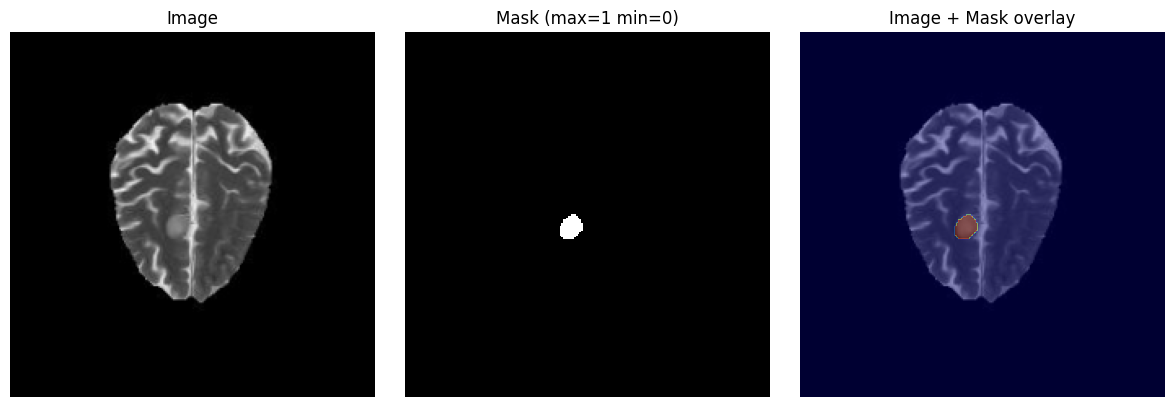

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


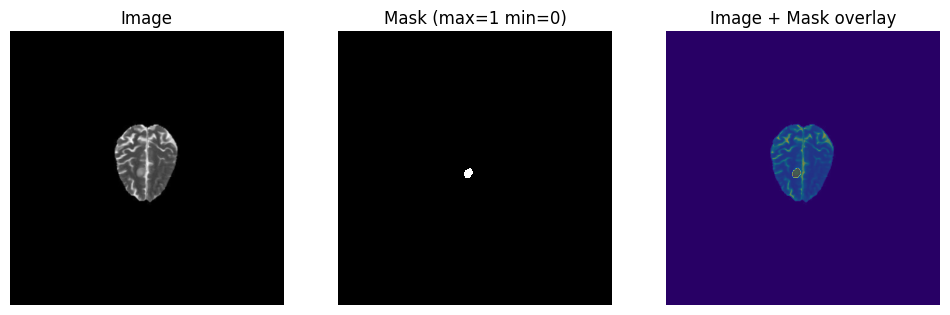

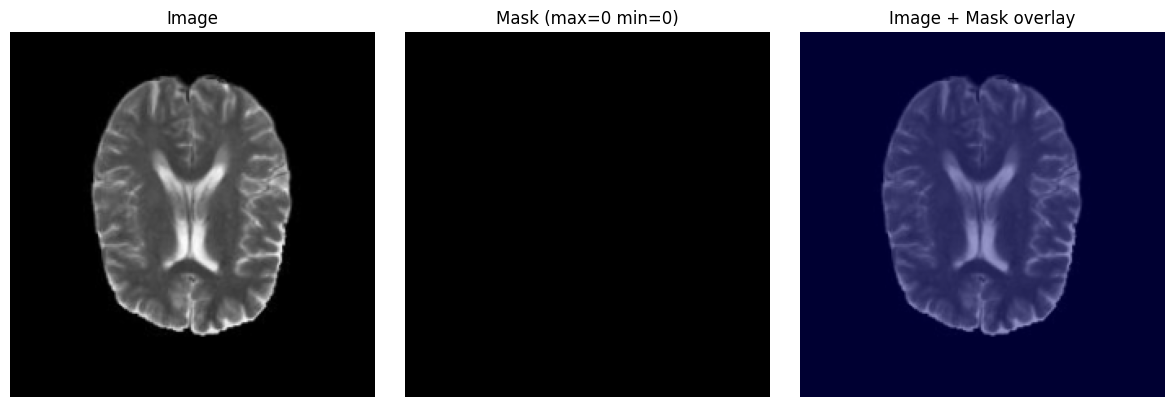

PADDING
VERTICAL flip
cen_t shape after flip rotate torch.Size([512, 512])


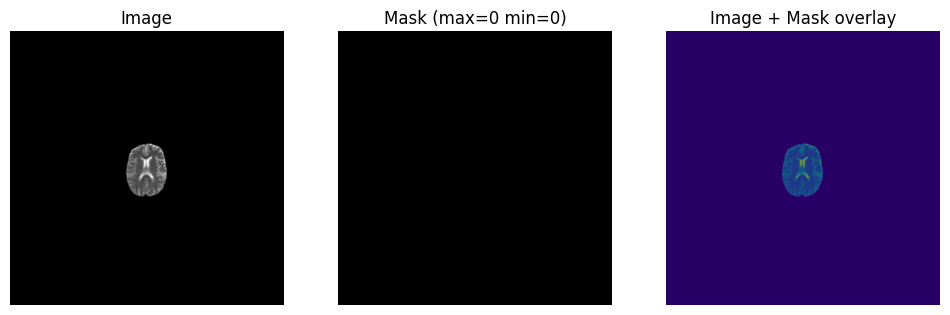

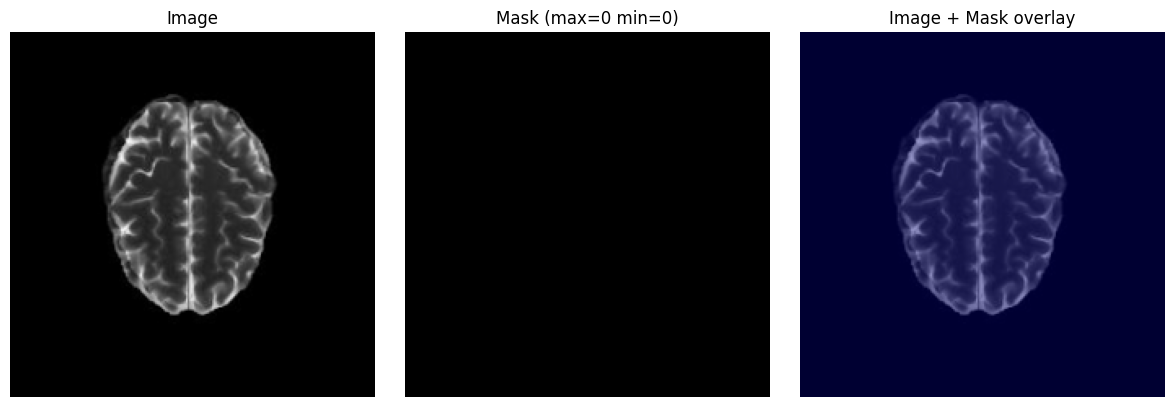

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


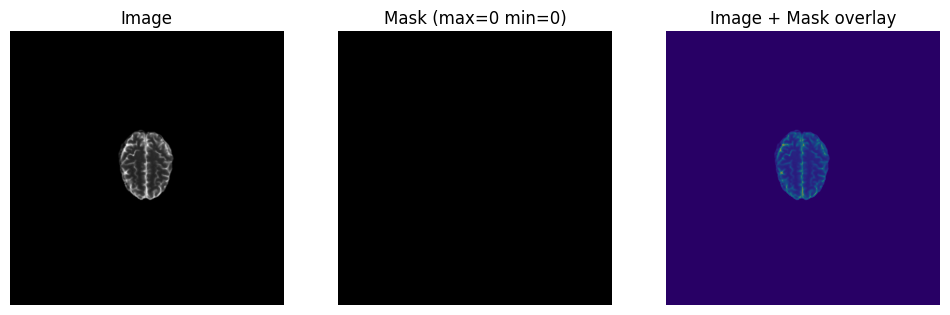

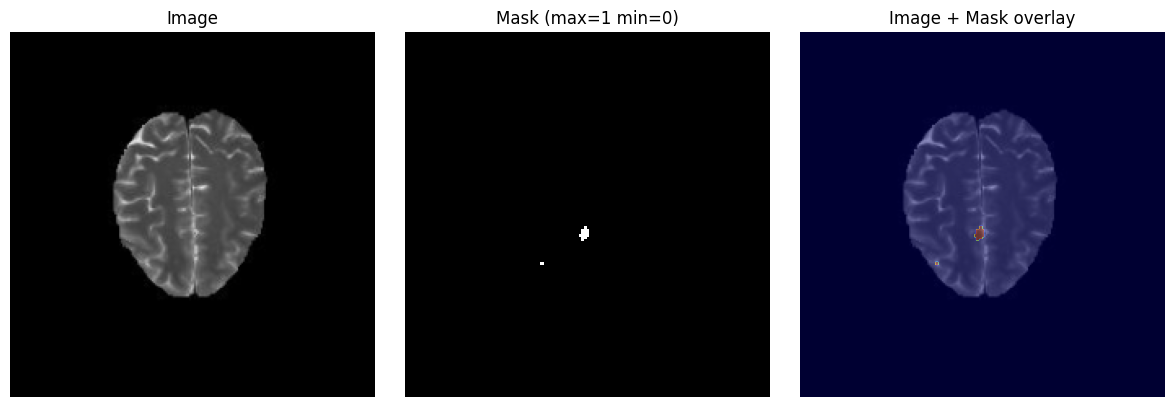

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


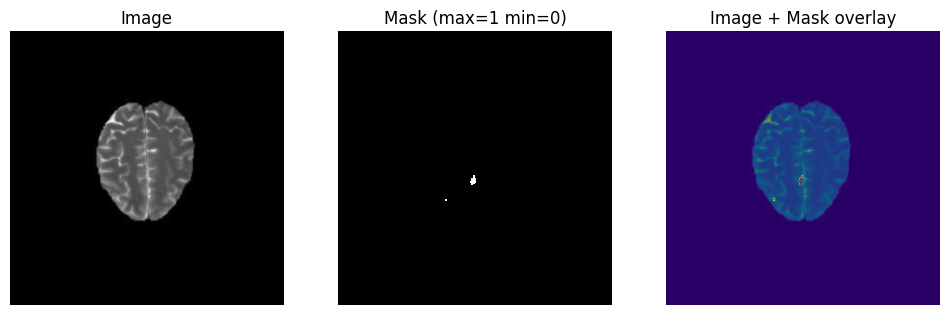

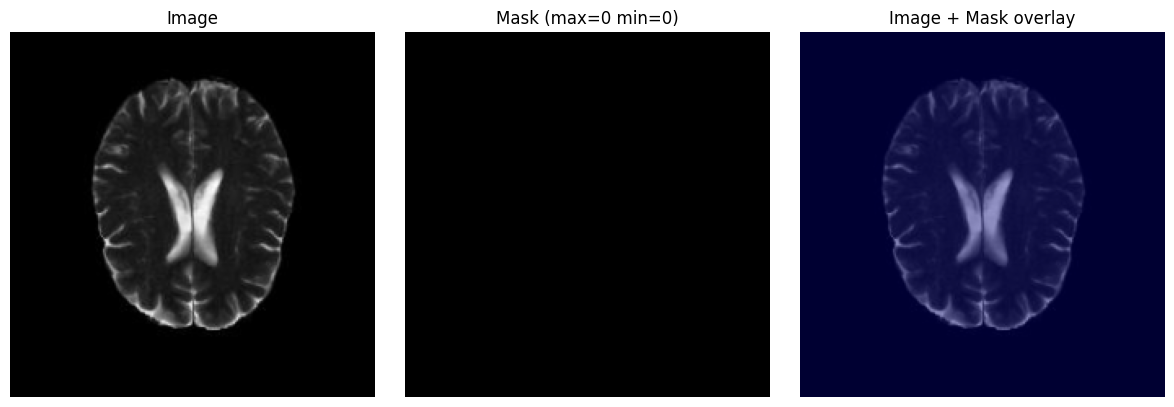

PADDING
ROTATION -2.089676387965012
cen_t shape after flip rotate torch.Size([512, 512])


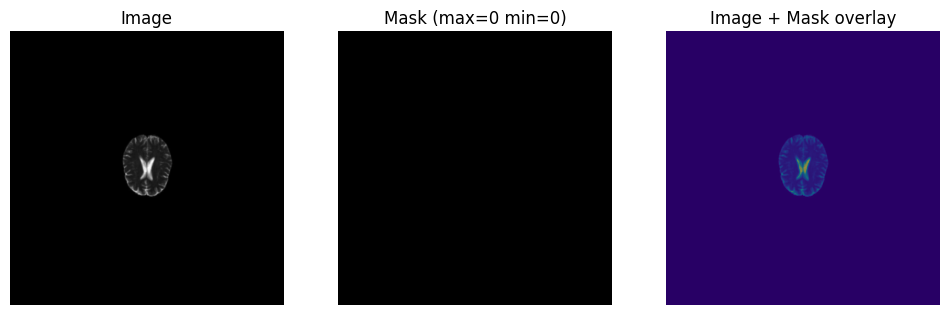

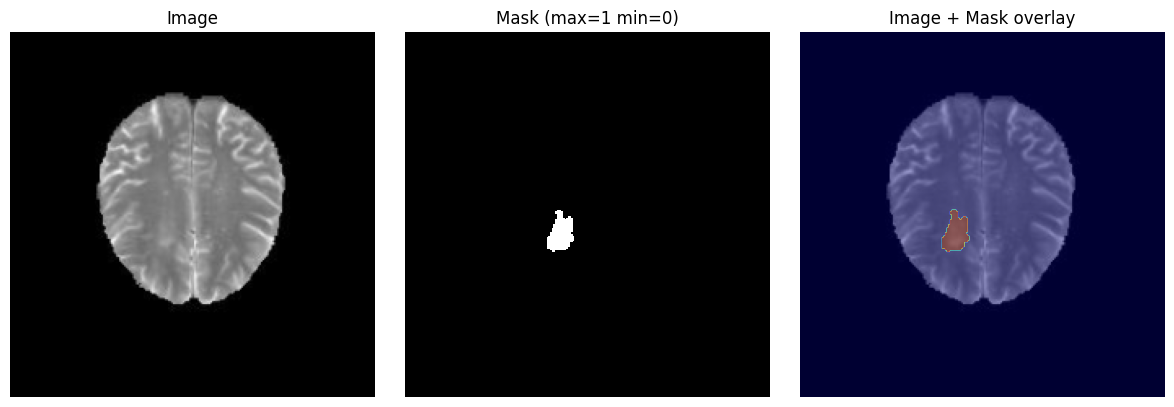

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


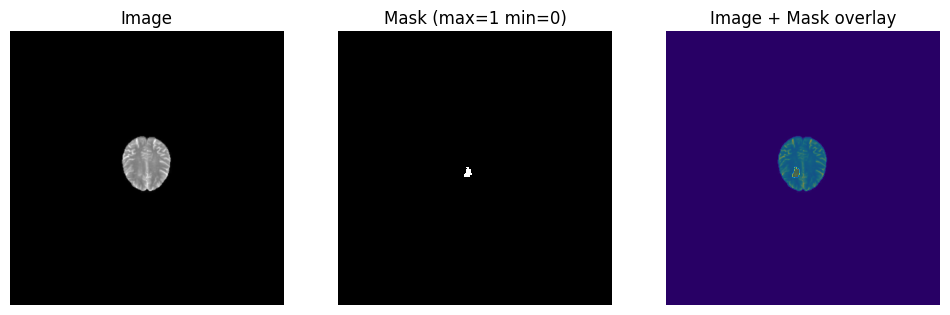

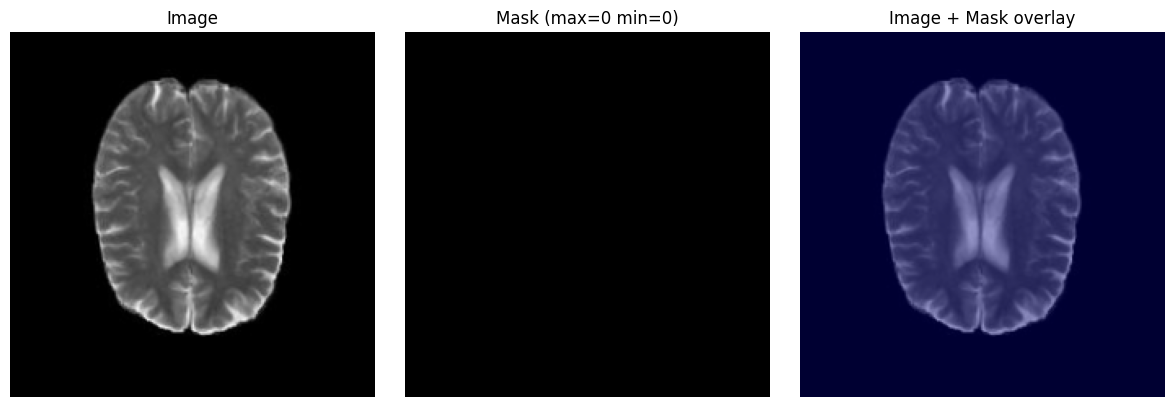

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


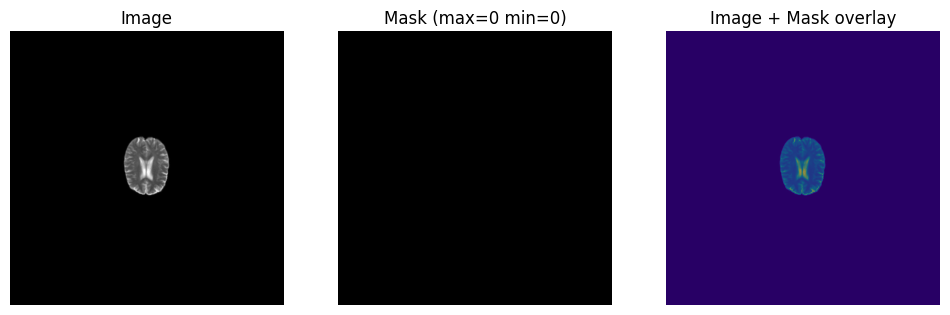

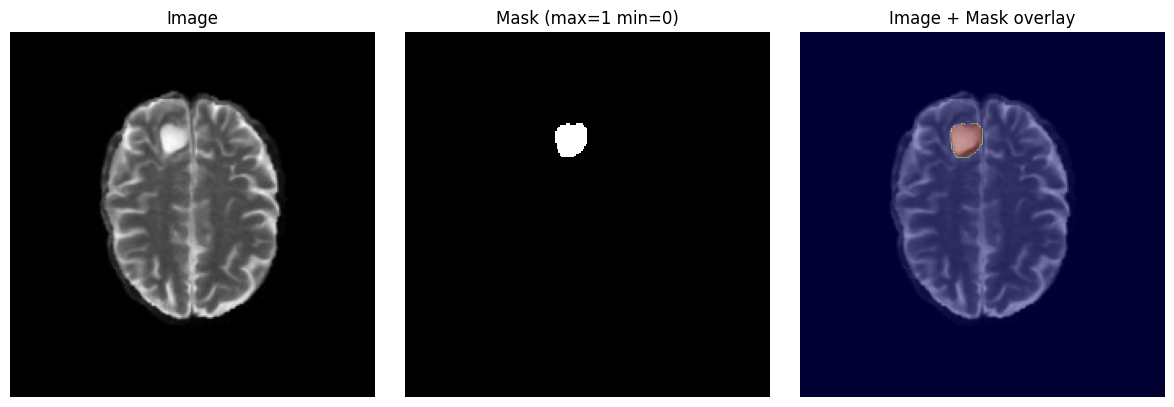

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


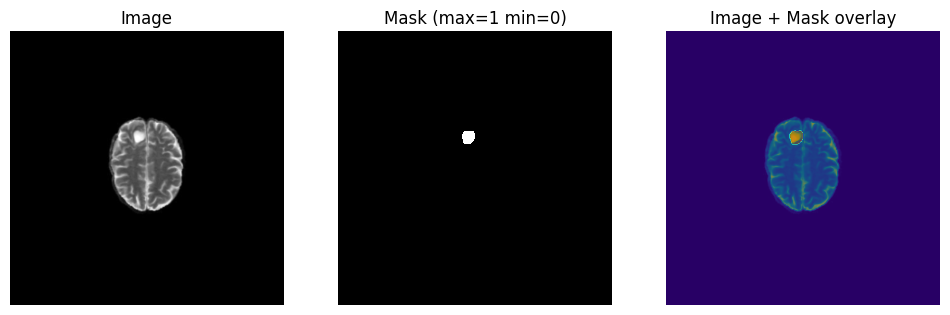

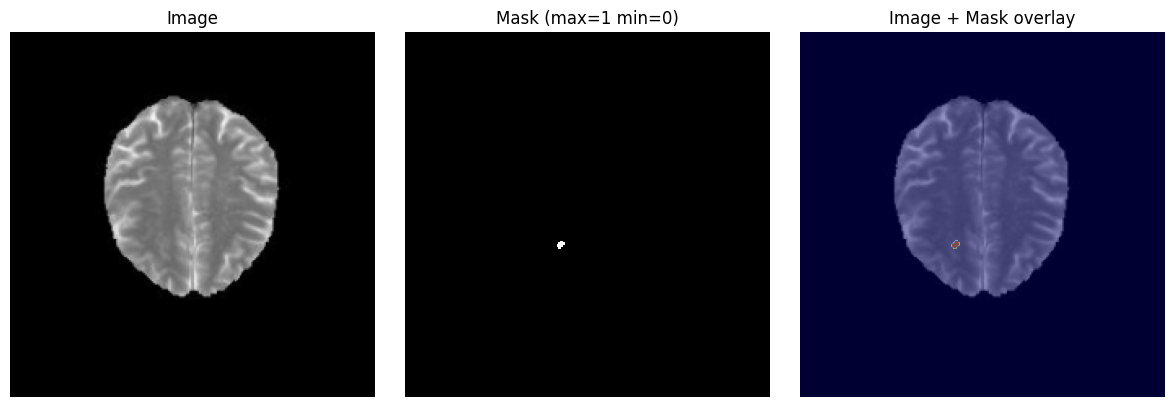

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


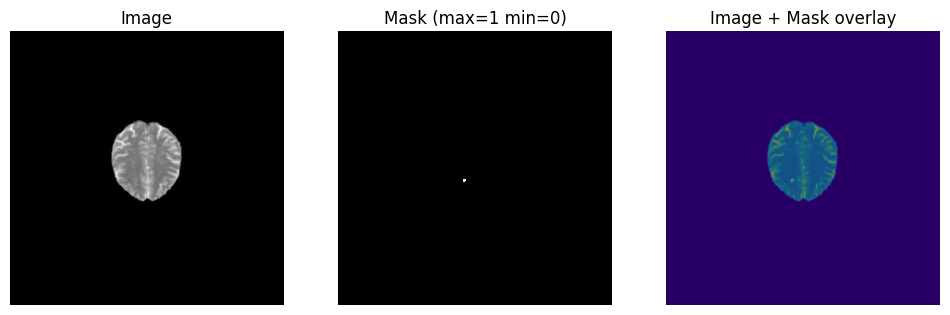

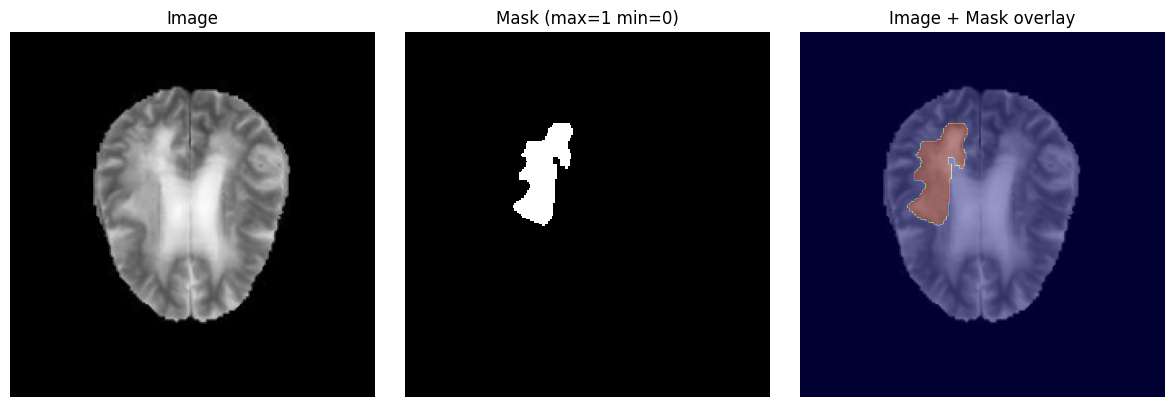

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


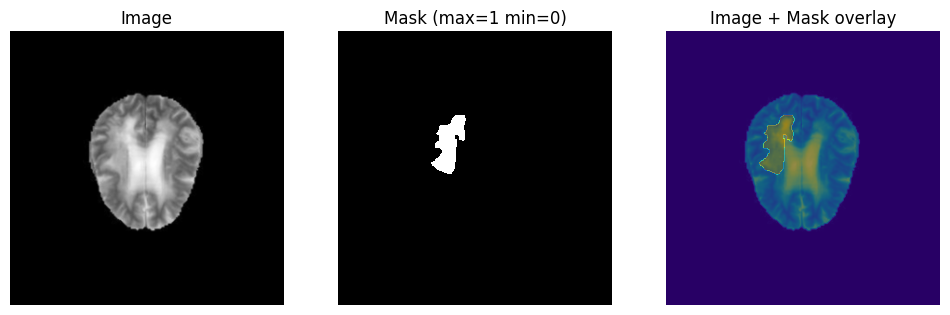

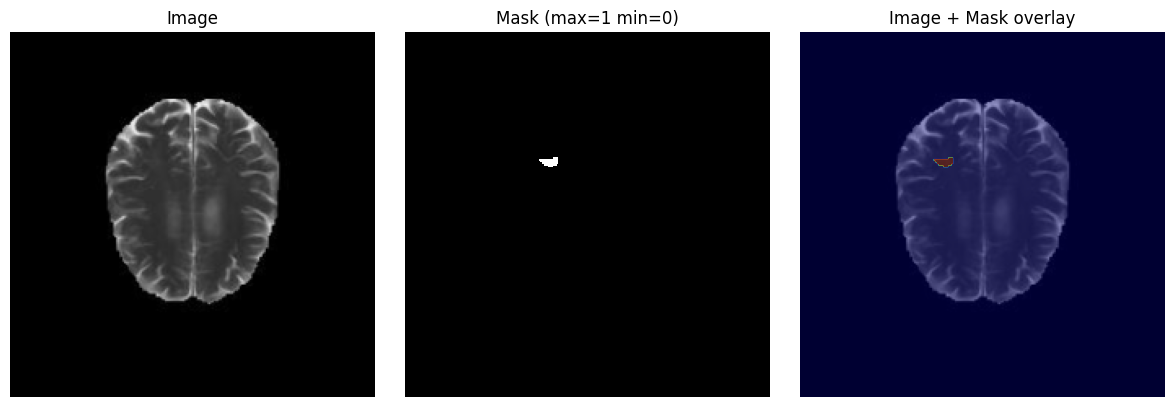

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


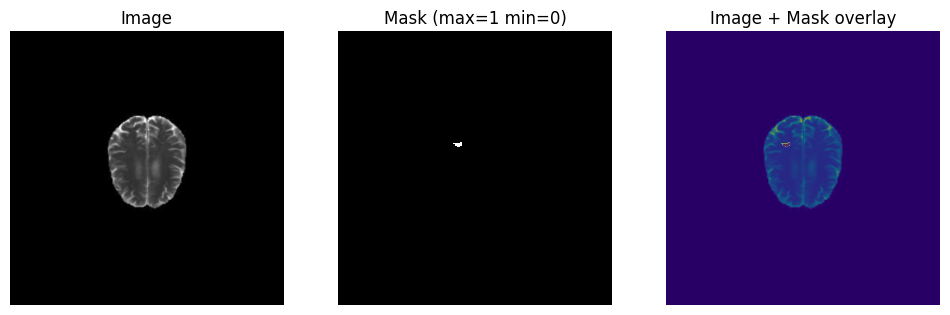

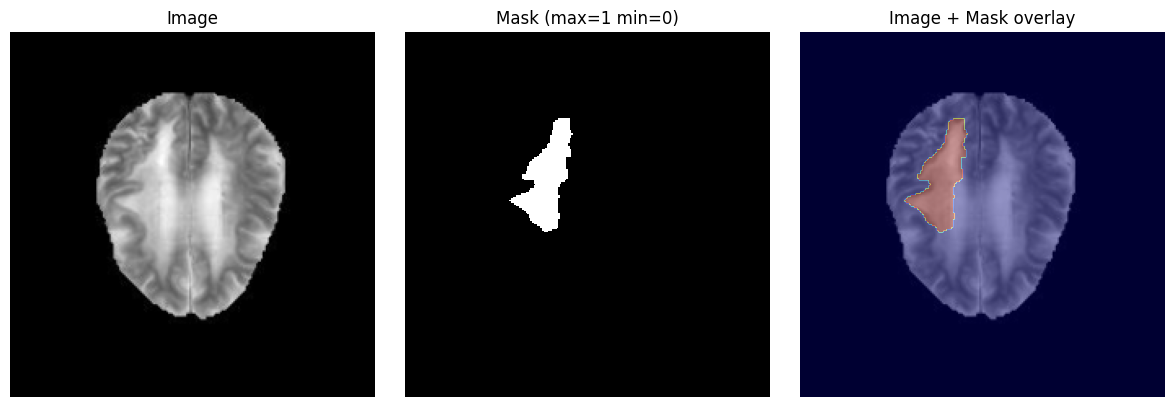

PADDING
HORIZONTAL flip
cen_t shape after flip rotate torch.Size([512, 512])


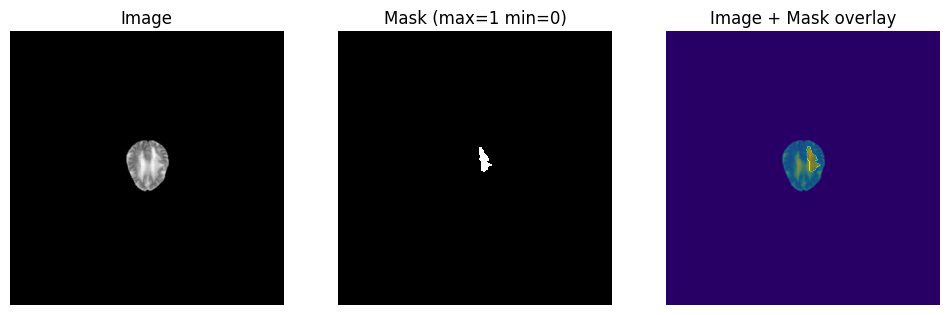

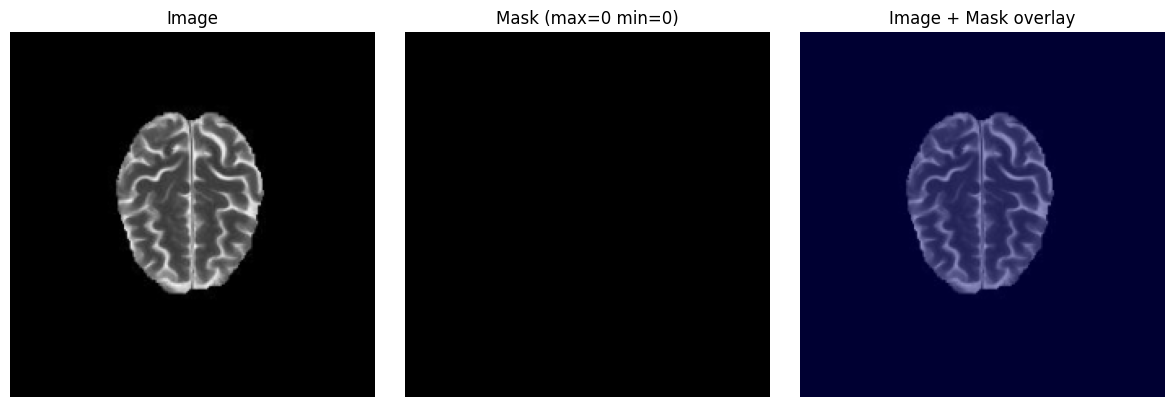

PADDING
ROTATION -7.719401497316802
cen_t shape after flip rotate torch.Size([512, 512])


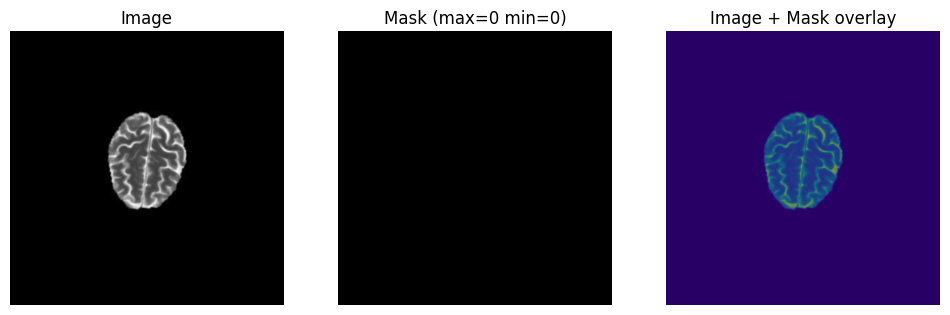

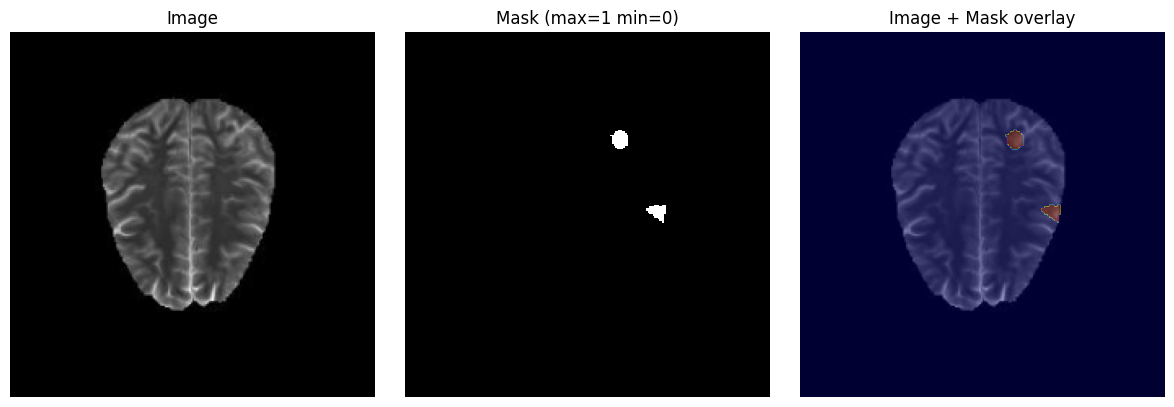

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


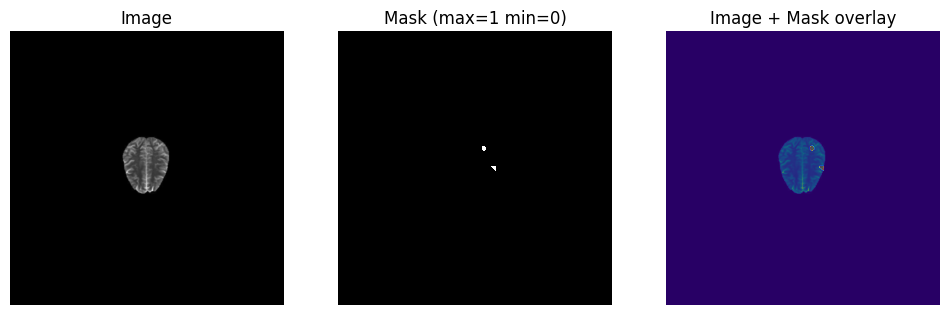

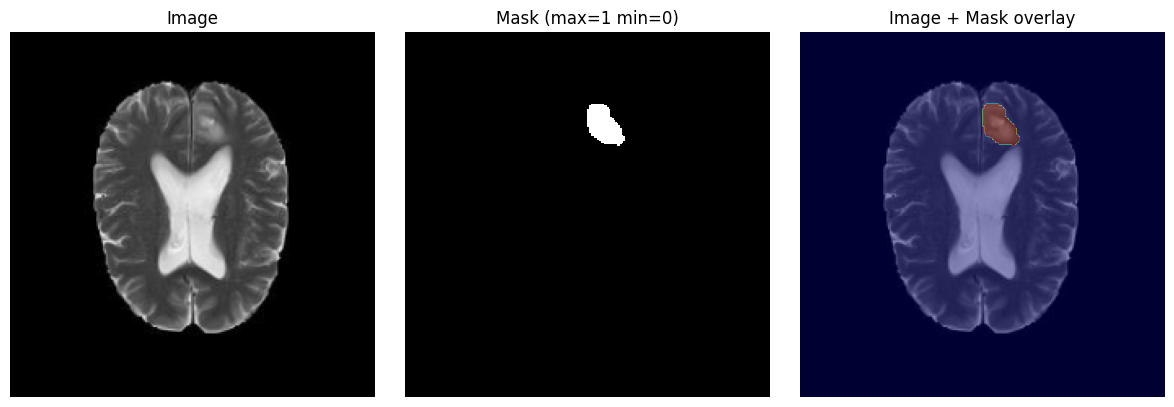

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


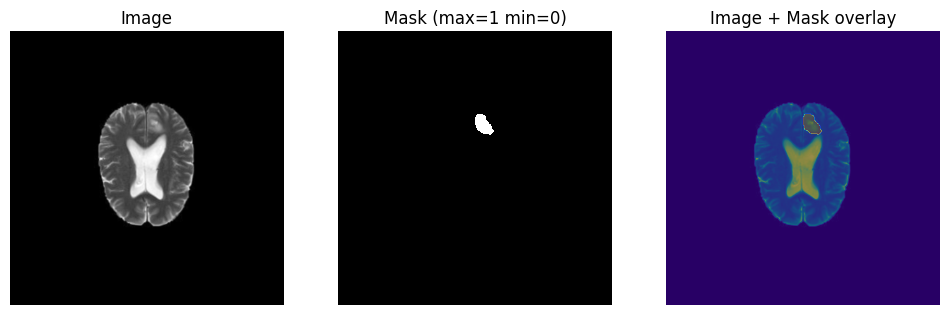

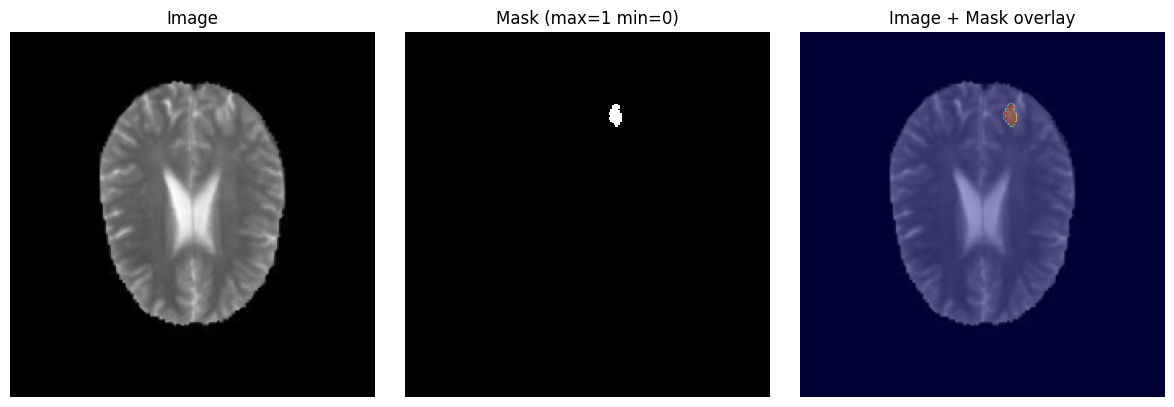

PADDING
ROTATION -7.200415400903573
cen_t shape after flip rotate torch.Size([512, 512])


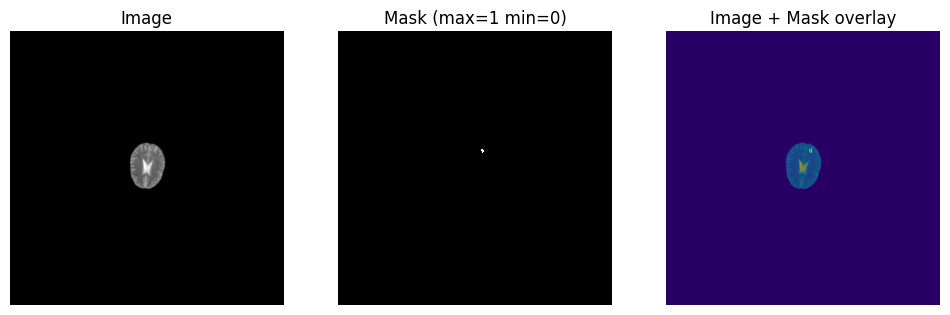

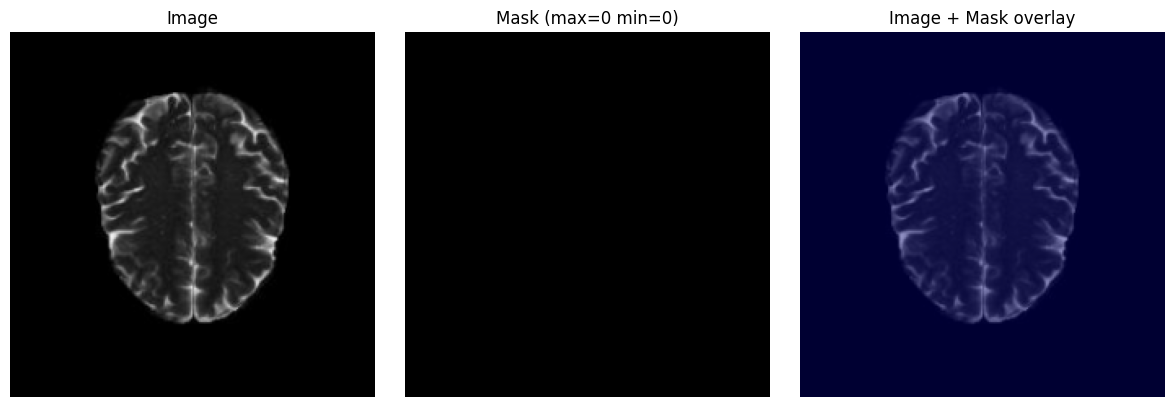

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


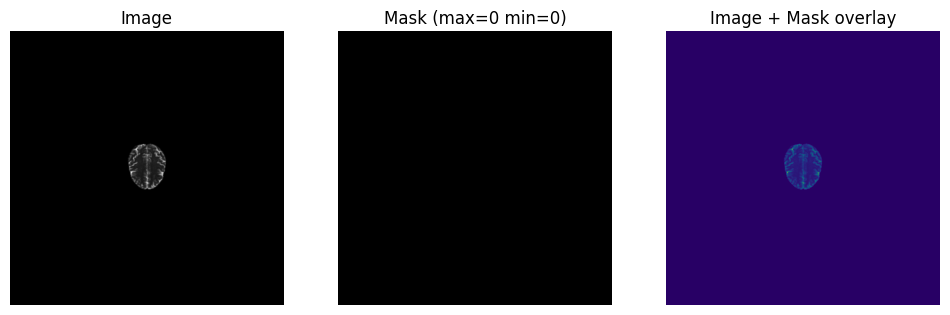

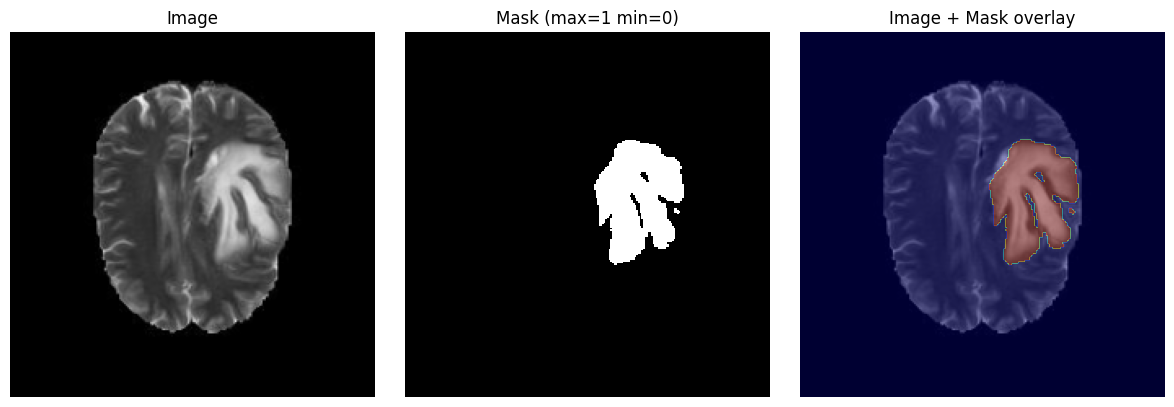

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


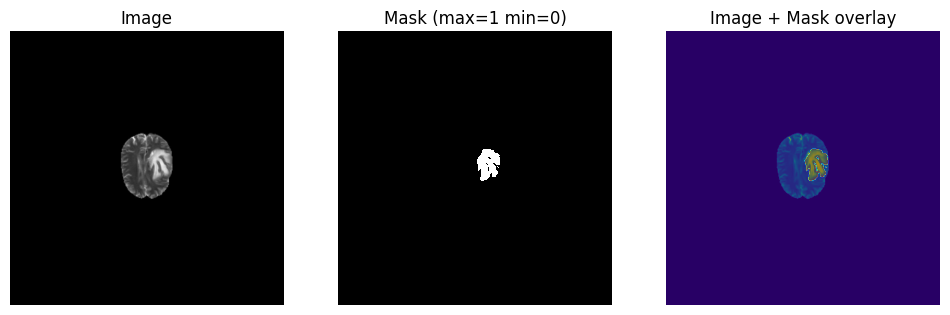

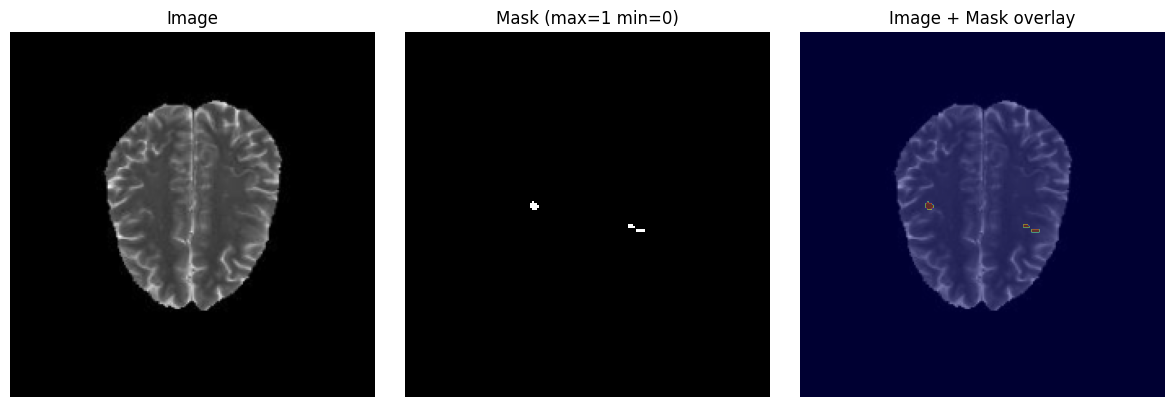

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


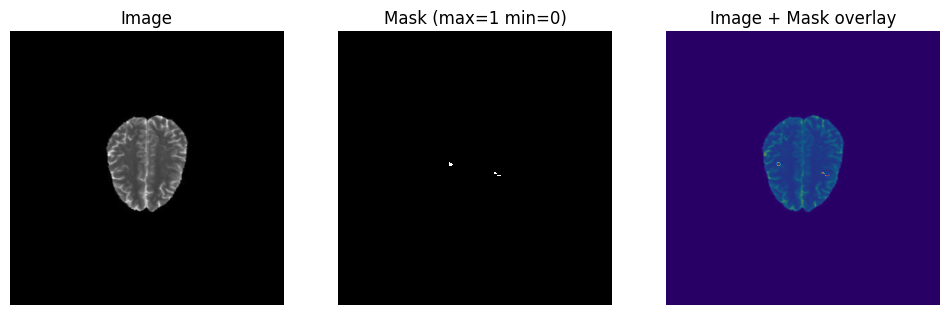

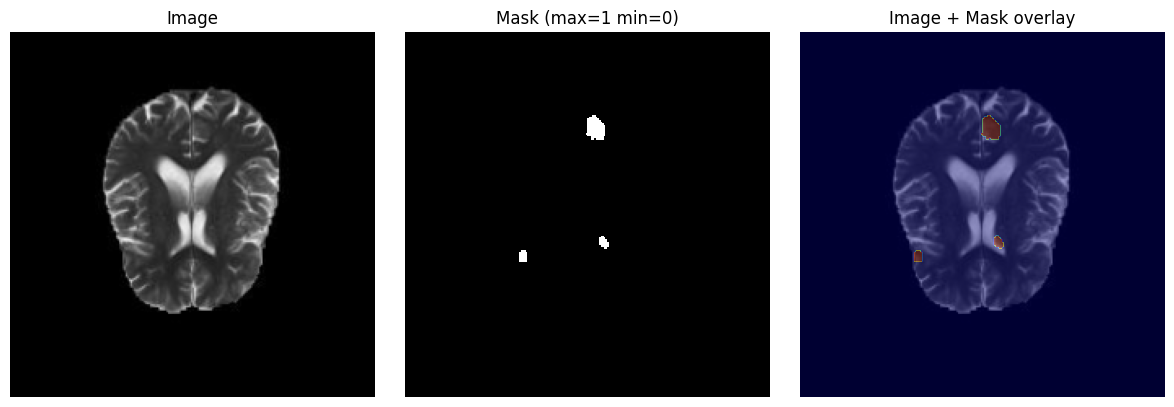

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


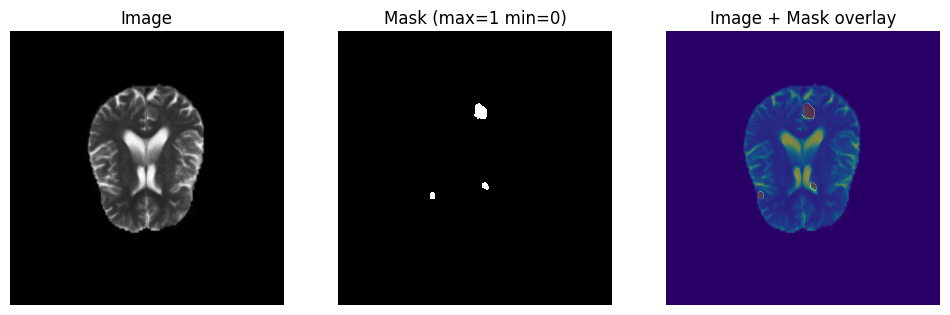

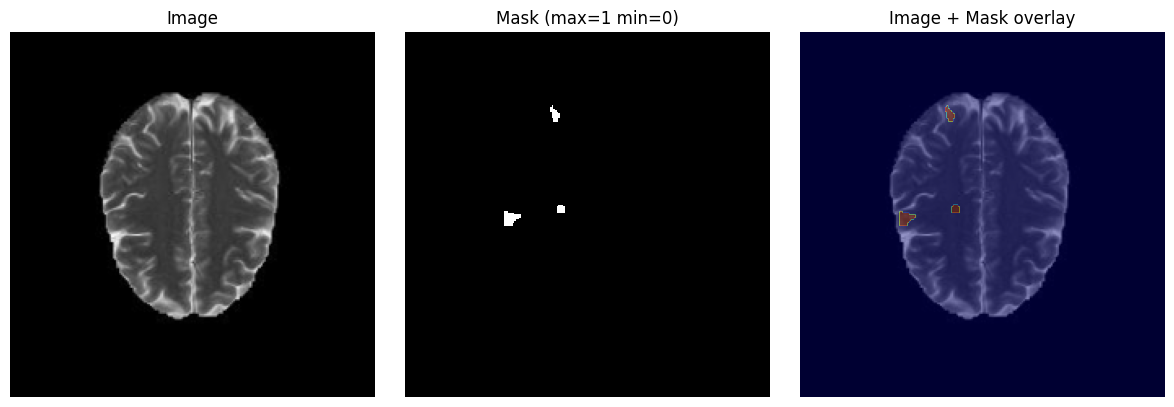

PADDING
VERTICAL flip
ROTATION -4.040401332960688
cen_t shape after flip rotate torch.Size([512, 512])


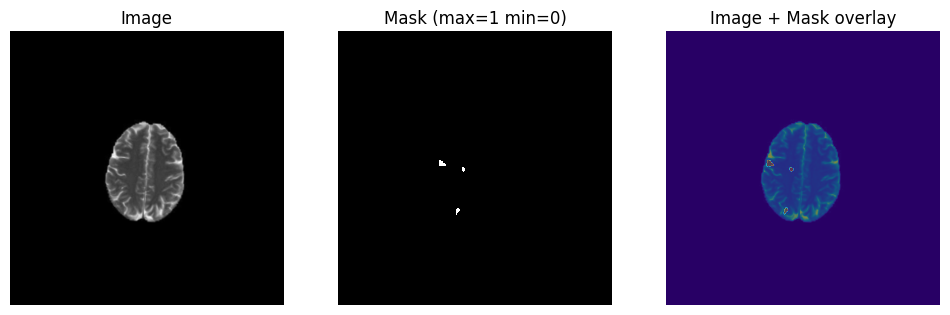

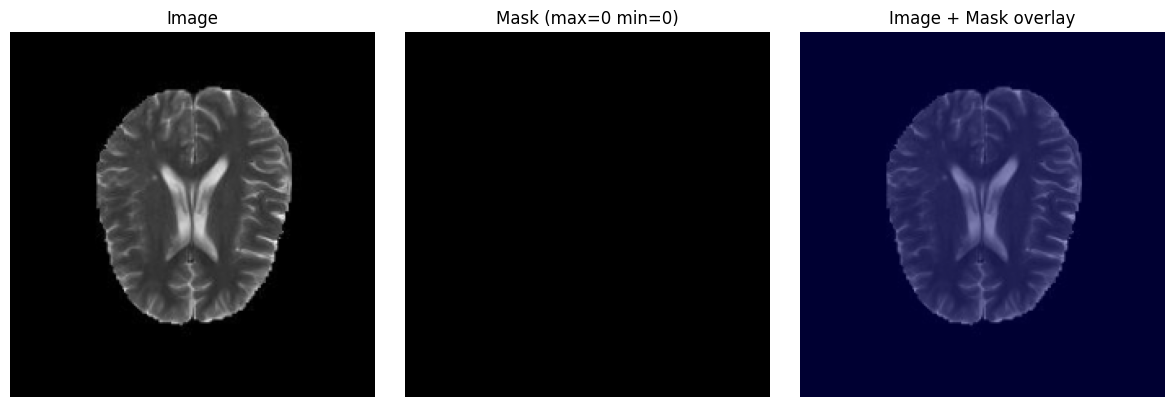

PADDING
cen_t shape after flip rotate torch.Size([512, 512])


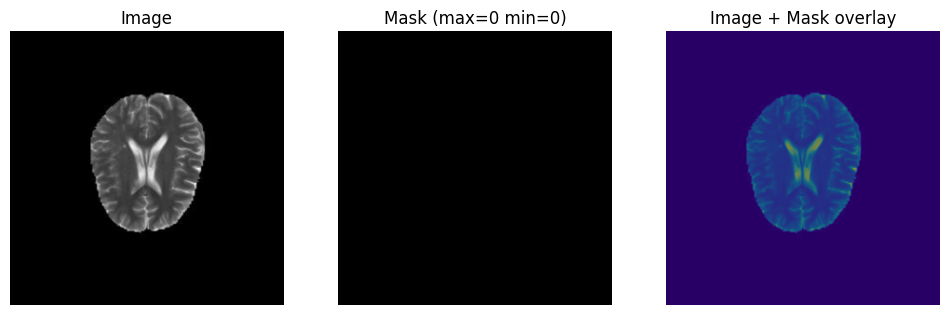

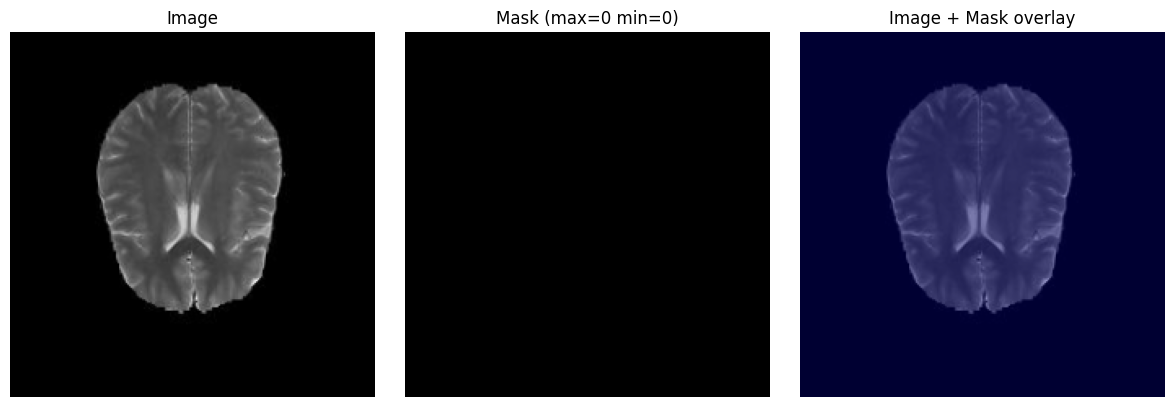

PADDING
HORIZONTAL flip
cen_t shape after flip rotate torch.Size([512, 512])


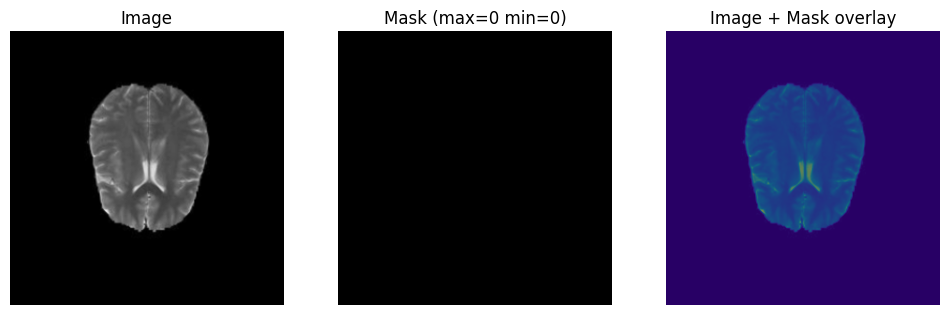

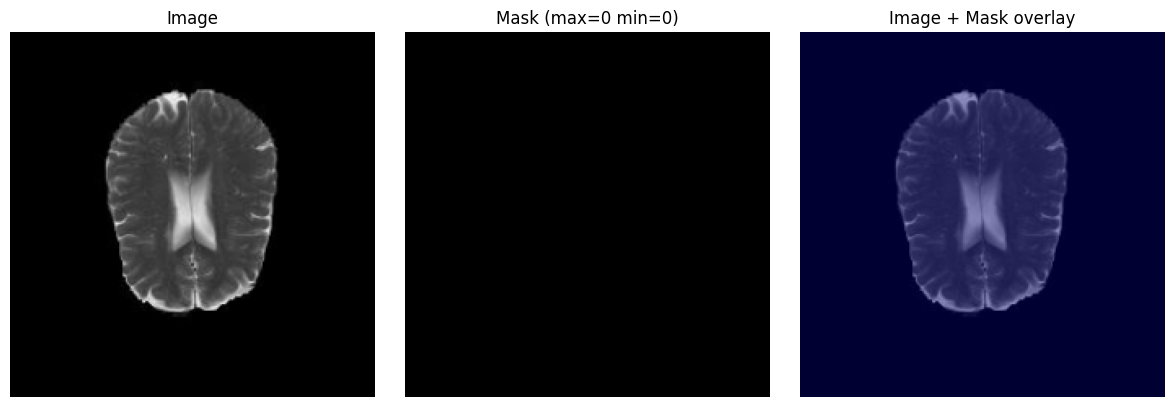

PADDING
HORIZONTAL flip
cen_t shape after flip rotate torch.Size([512, 512])


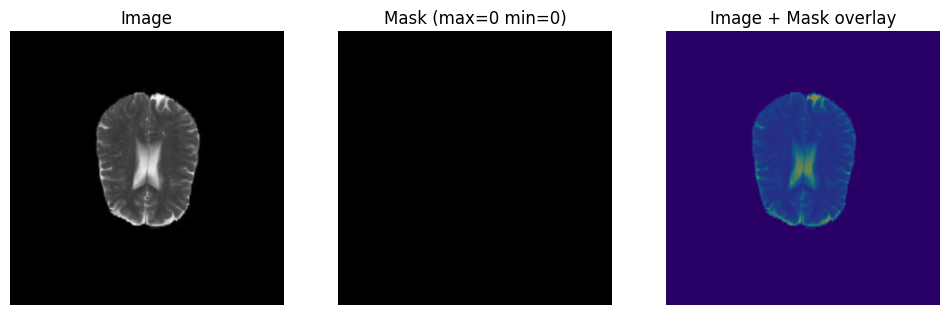

In [136]:
# TODO: #5 check that effectively the masks are rotated/flipped the same way as the images
parser = argparse.ArgumentParser(description="Train MediCLIP")
parser.add_argument(
    "--config_path", type=str, default="config/brats-met.yaml", help="model configs"
)
parser.add_argument("--k_shot", type=int, default=32, help="normal image number") # ! change #kshot
parser.add_argument(
    "--patients",
    type=bool,
    default=False,
    help="whether to k-shot refers to patients",
)
parser.add_argument("--checkpoint_path", type=str, help="the checkpoint path", default=None)
parser.add_argument('--pmc', type=bool, help = 'use pmc as backbone', default=True) 
args, unknown = parser.parse_known_args()
#torch.multiprocessing.set_start_method("spawn")
main(args)

In [70]:
model.backbone.embeddings.patch_embeddings.conv3d.proj.weight[0]

tensor([[[[ 1.8260e-03,  2.2050e-03,  2.4765e-03,  2.5788e-03],
          [ 1.9642e-03,  2.4367e-03,  2.8096e-03,  2.9846e-03],
          [ 2.0927e-03,  2.6238e-03,  3.0991e-03,  3.3309e-03],
          [ 2.2804e-03,  2.7764e-03,  3.2440e-03,  3.4973e-03]],

         [[ 1.4025e-03,  1.7671e-03,  2.0192e-03,  2.1662e-03],
          [ 1.6091e-03,  2.0900e-03,  2.4881e-03,  2.6996e-03],
          [ 1.8341e-03,  2.3994e-03,  2.9269e-03,  3.1938e-03],
          [ 2.0735e-03,  2.6363e-03,  3.1801e-03,  3.4814e-03]],

         [[ 2.2350e-03,  7.6546e-02, -1.6033e-01, -2.0453e-01],
          [ 5.1047e-02,  2.1255e-01,  6.3827e-02,  1.3684e-01],
          [-4.9487e-02, -1.1796e-02,  7.3689e-02,  2.6794e-02],
          [-1.4970e-01, -9.2993e-02, -7.7334e-02,  8.4358e-02]],

         [[ 5.5737e-04,  8.8716e-04,  1.1120e-03,  1.1418e-03],
          [ 7.5864e-04,  1.1798e-03,  1.5201e-03,  1.6029e-03],
          [ 9.4467e-04,  1.4238e-03,  1.8478e-03,  1.9854e-03],
          [ 1.1625e-03,  1.6071e-0

In [71]:
model.decode_head.classifier.weight[0]

tensor([[[ 2.4266e-02]],

        [[-1.0597e-02]],

        [[-4.4014e-02]],

        [[ 5.7009e-02]],

        [[ 9.7497e-03]],

        [[ 2.7357e-02]],

        [[ 1.6915e-03]],

        [[ 3.2279e-02]],

        [[-3.4417e-02]],

        [[-2.5385e-02]],

        [[ 2.2408e-02]],

        [[ 1.1611e-03]],

        [[ 1.2188e-02]],

        [[-3.5351e-02]],

        [[ 1.9480e-02]],

        [[-2.9830e-02]],

        [[-6.9873e-03]],

        [[-1.8354e-02]],

        [[-4.1886e-02]],

        [[ 2.1816e-02]],

        [[-1.2810e-02]],

        [[ 4.3457e-03]],

        [[-4.2346e-02]],

        [[ 4.0877e-02]],

        [[-3.1181e-02]],

        [[-1.9732e-02]],

        [[-4.8393e-02]],

        [[-4.0371e-02]],

        [[ 6.8551e-04]],

        [[-1.3204e-02]],

        [[ 1.8837e-02]],

        [[ 1.3090e-02]],

        [[ 4.9832e-02]],

        [[-7.1199e-03]],

        [[-1.6889e-02]],

        [[-4.4004e-02]],

        [[ 2.4600e-03]],

        [[ 4.2120e-02]],

        [[-2

### BEiT

In [ ]:
from transformers import BeitModel, SwinModel, AutoModel
enc = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
# BEiT encoder's weights from ImageNet-22k
enc
from transformers import BeitConfig, UperNetConfig, UperNetForSemanticSegmentation

beit_backbone = BeitConfig(
    output_hidden_states=True,
    out_indices=[2, 5, 8, 11]   # can be tweaked
)
cfg = UperNetConfig(backbone_config=beit_backbone, num_labels=2)
model = UperNetForSemanticSegmentation(cfg)
# decoder's weights RANDOMLY INITIALIZED
model